In [1]:
import json
import argparse
import os
import random
import sys
import logging
import numpy as np
import pandas as pd

from utils import load_file
#import plot_utils

import seaborn as sns
import matplotlib.pyplot as plt

Enter your parameters:

In [2]:
data=[
    # {
    #     'model': 'bert-base-cased',
    #     'prompts': 'LAMA_relations'
    # },
    # {
    #     'model': 'gpt2',
    #     'prompts': 'LAMA_relations'
    # },
    {
        'model': 'facebook_opt-350m',
        'prompts': 'LAMA_relations_2_opt350'
    },
  
    # {
    #     'model': 'gpt2',
    #     'prompts': 'gpt2_autoprompt_seed_0'
    # }
]
rel_id='all' # 'all' if you want to inspect all the relations

In [3]:
relations = 'P1001 P101 P103 P106 P108 P127 P1303 P131 P136 P1376 P138 P140 P1412 P159 P17 P176 P178 P19 P190 P20 P264 P27 P276 P279 P30 P31 P36 P361 P364 P37 P39 P407 P413 P449 P463 P47 P495 P527 P530 P740 P937'.split()
# output_dir = {m:os.path.join('../output', prompts, m) for m in model}
LAMA_template = os.path.join('../prompts', 'LAMA_relations'+'.jsonl')

A function to compute the entropy

In [4]:
def get_rel_stats(relation, dir):
    rel_tot = 0
    rel_cor = 0
    rel_pred_stat = {}
    rel_gold_stat = {}
    samples = load_file(os.path.join(dir, '%s.jsonl'%(relation)))

    for sample in samples:
        rel_pred=sample['topk'][0]['token']

        # Store all top-1 predicted answers
        if rel_pred in rel_pred_stat:
            rel_pred_stat[rel_pred] += 1
        else:
            rel_pred_stat[rel_pred] = 1

        # Store all gold answers
        rel_gold = sample['obj_label']
        if rel_gold in rel_gold_stat:
            rel_gold_stat[rel_gold] += 1
        else:
            rel_gold_stat[rel_gold] = 1

        # Is the answer correct
        if rel_gold == rel_pred:
            rel_cor += 1
        rel_tot += 1

    # normalise
    rel_pred_stat = {k:float(v)/float(rel_tot) for k,v in rel_pred_stat.items()}
    rel_gold_stat = {k:float(v)/float(rel_tot) for k,v in rel_gold_stat.items()}
    

    return (rel_cor,rel_tot), rel_pred_stat, rel_gold_stat

In [5]:
def display_ans_dist(rel_pred_stats, fig, only_head=False):
    d = {'label':list(rel_pred_stats.keys()), 'n':list(rel_pred_stats.values())}
    df = pd.DataFrame(data=d)
    if len(df) < 10 or only_head is False:
        n_head = len(df)
    else:
        n_head = int(0.2*len(df)) # top 20%
    df = df.sort_values('n', ascending=False).head(n_head)
    sns.barplot(x='label', y='n', data=df)

def display_ans_ent(rel_pred_stats, fig):
    pass

def entropy(v):
    base=2
    return np.sum(v * np.log(v)) / np.log(base)

def normentropy(v):
    # normalize the entropy by the entropy of a uniform vector of the same size
    d_v = np.array(len(v))
    uniform = np.ones(d_v)*1/d_v
    uniform_ent=entropy(uniform) 
    return entropy(v) / uniform_ent

def prop_top1(rel_pred_stats):
    return max(list(rel_pred_stats.values()))

P1001	69.89	(455 / 651)


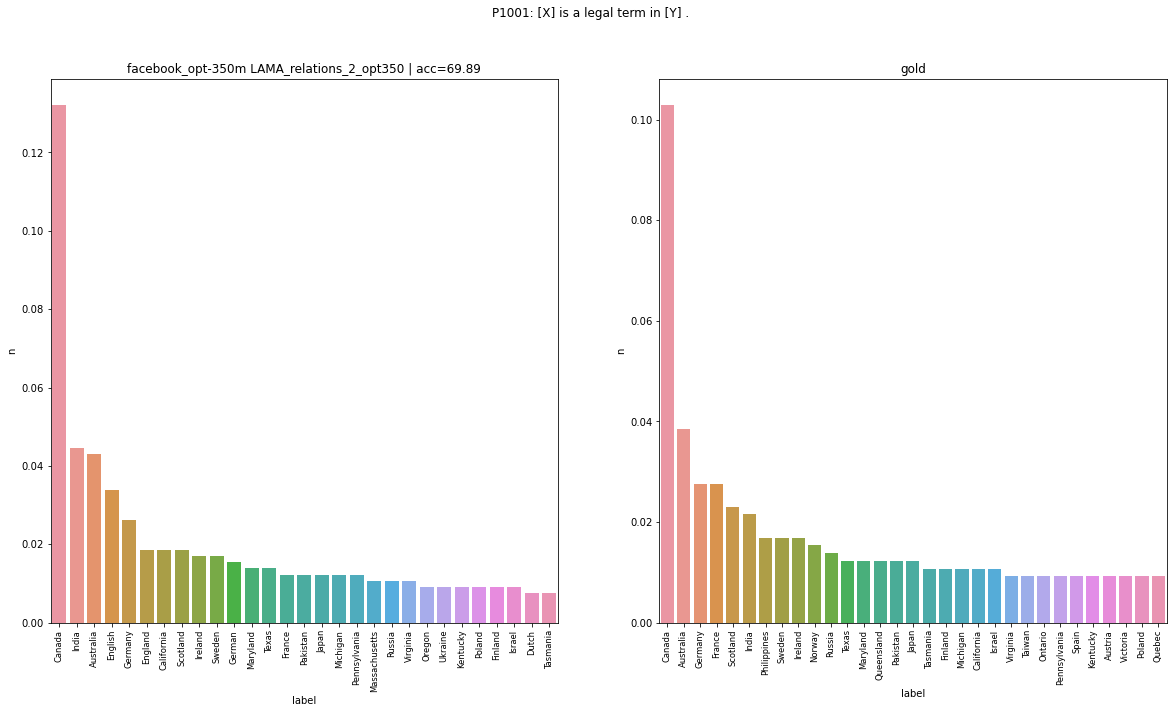

P101	5.54	(17 / 307)


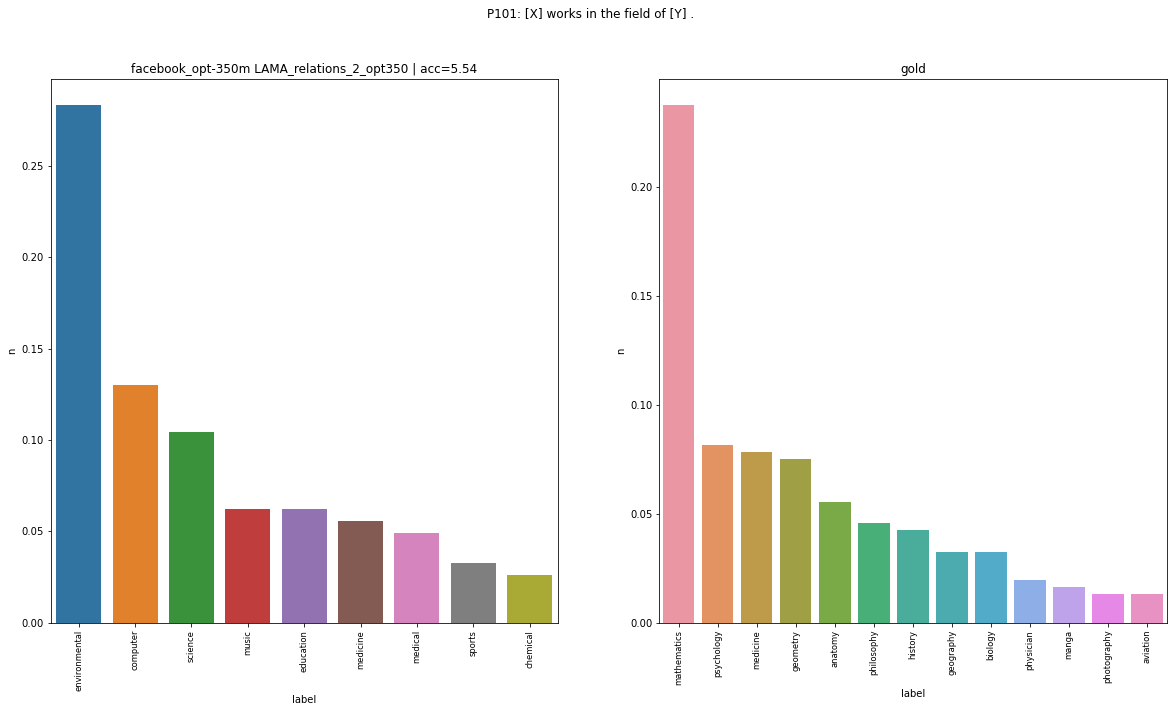

P103	70.74	(643 / 909)


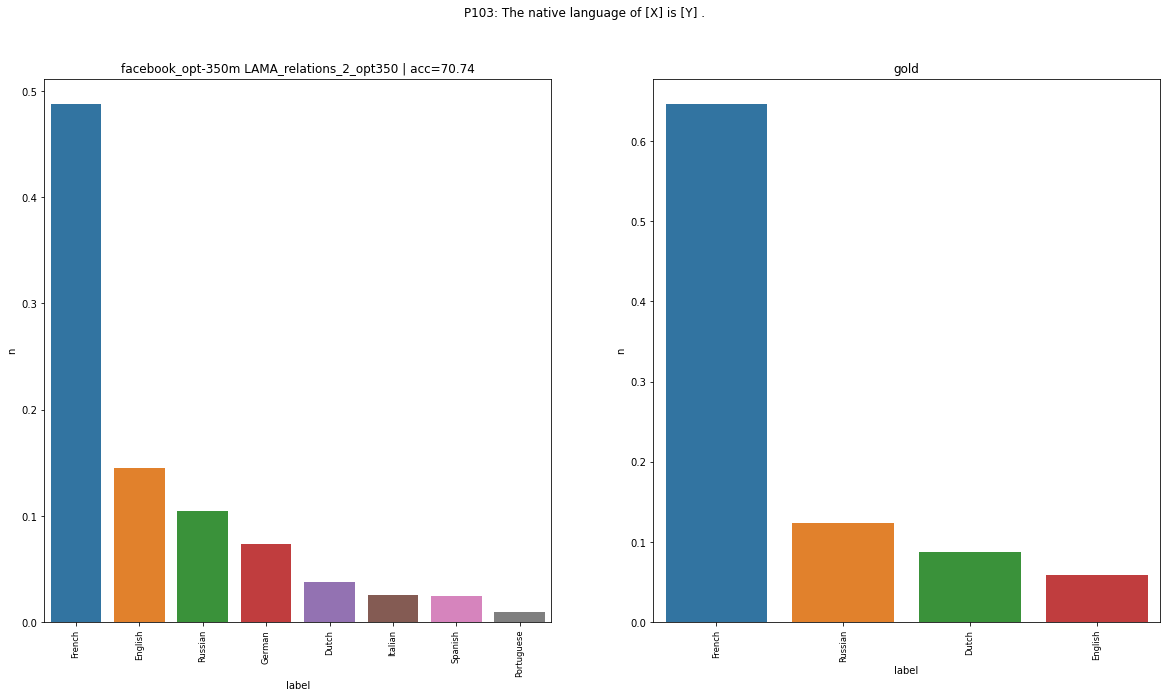

P106	0.27	(2 / 750)


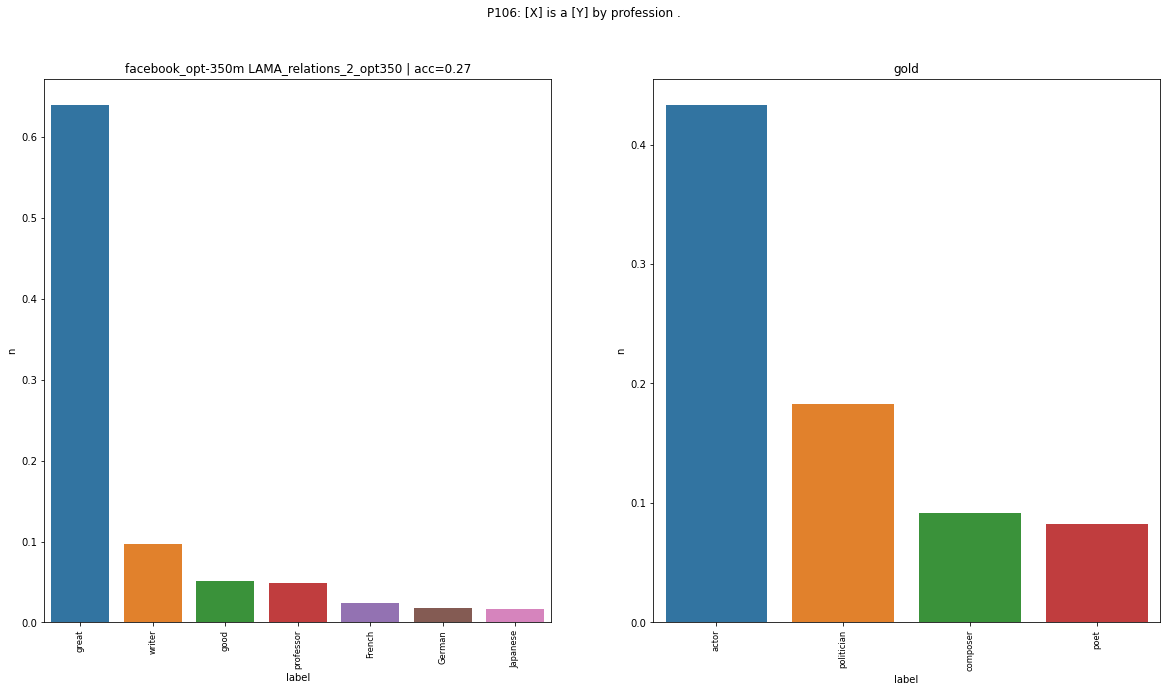

P108	7.69	(28 / 364)


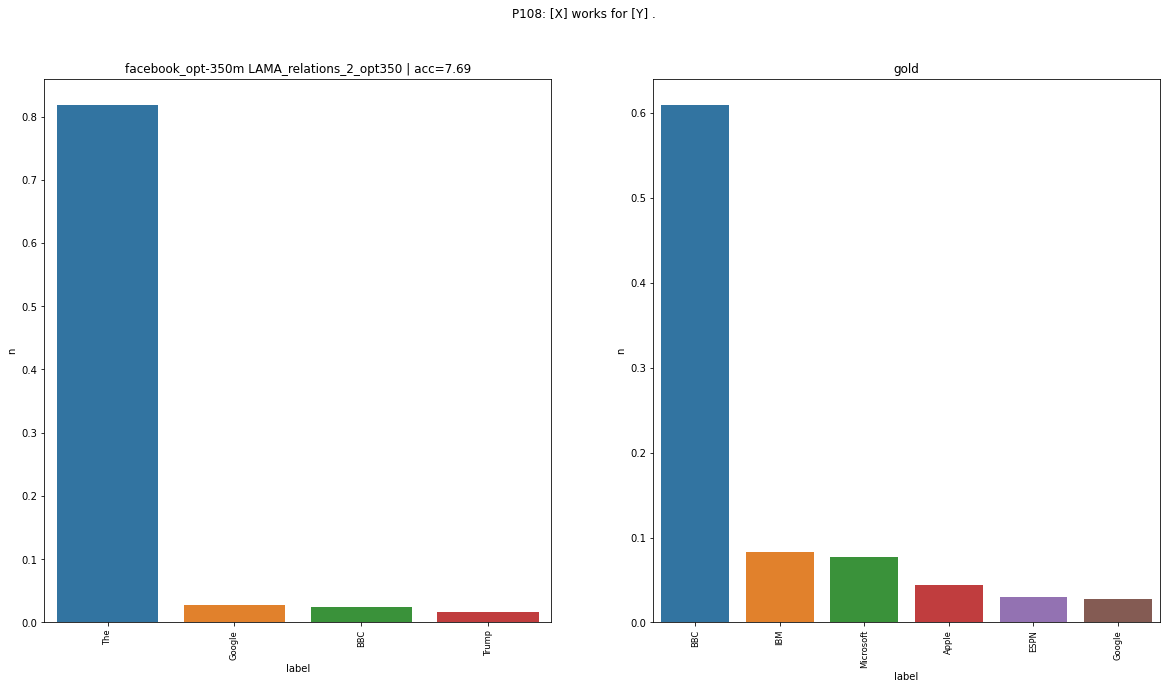

P127	39.43	(220 / 558)


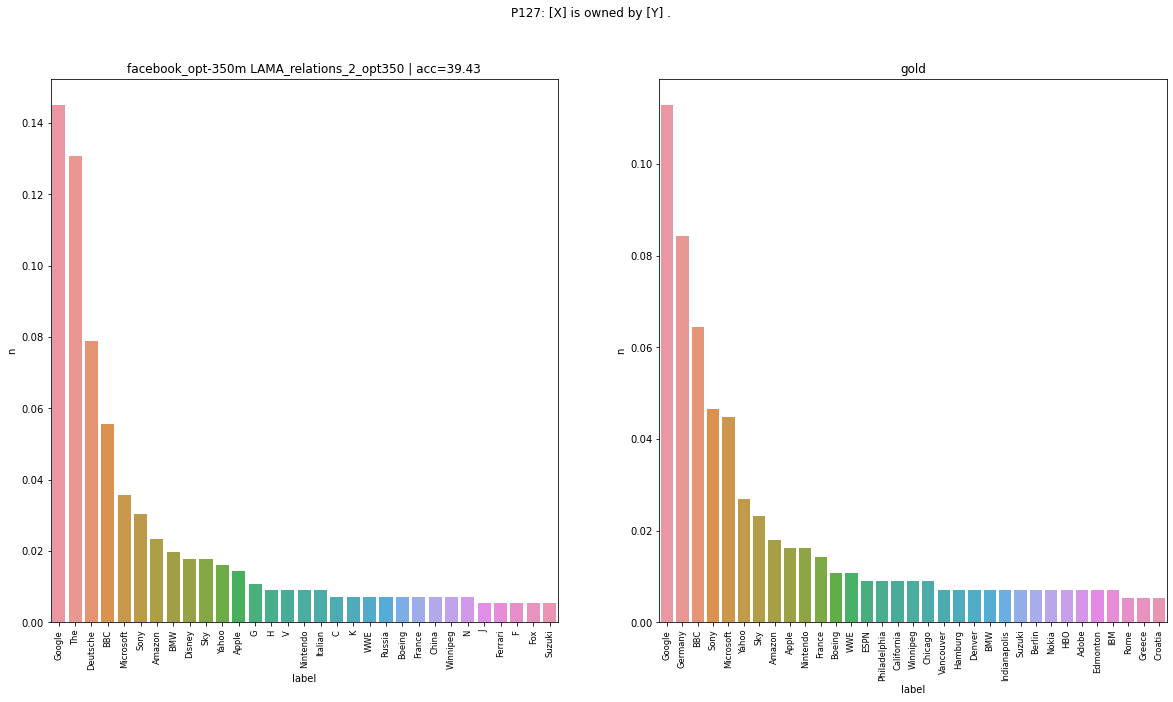

P1303	12.09	(62 / 513)


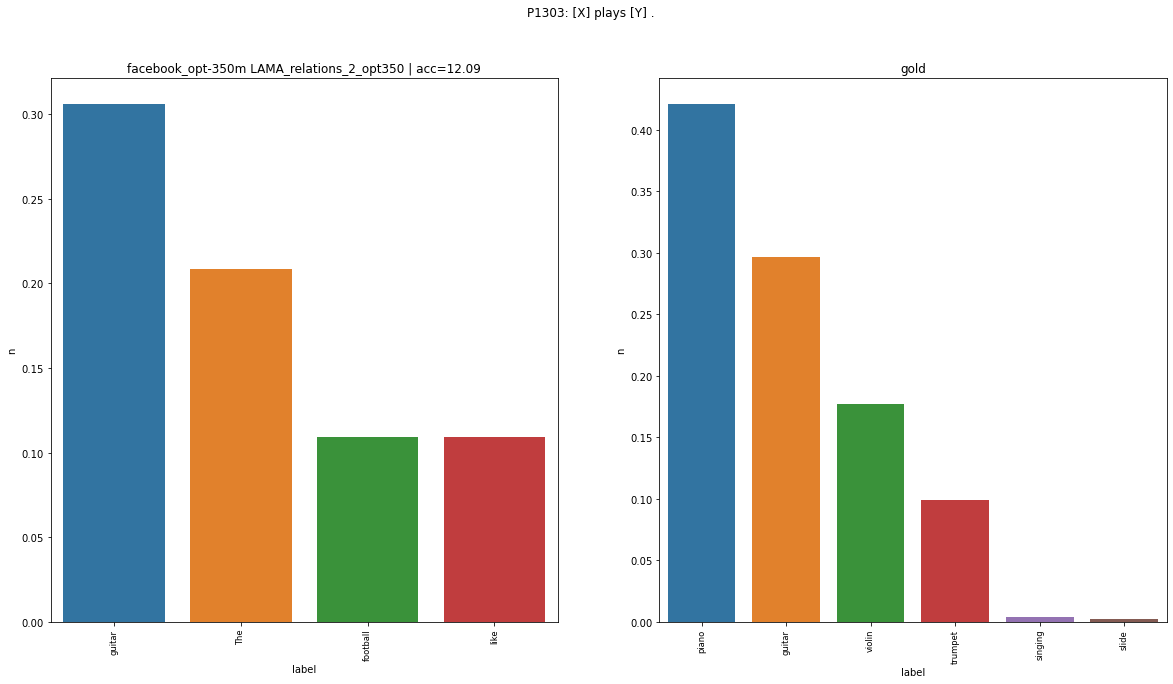

P131	16.94	(124 / 732)


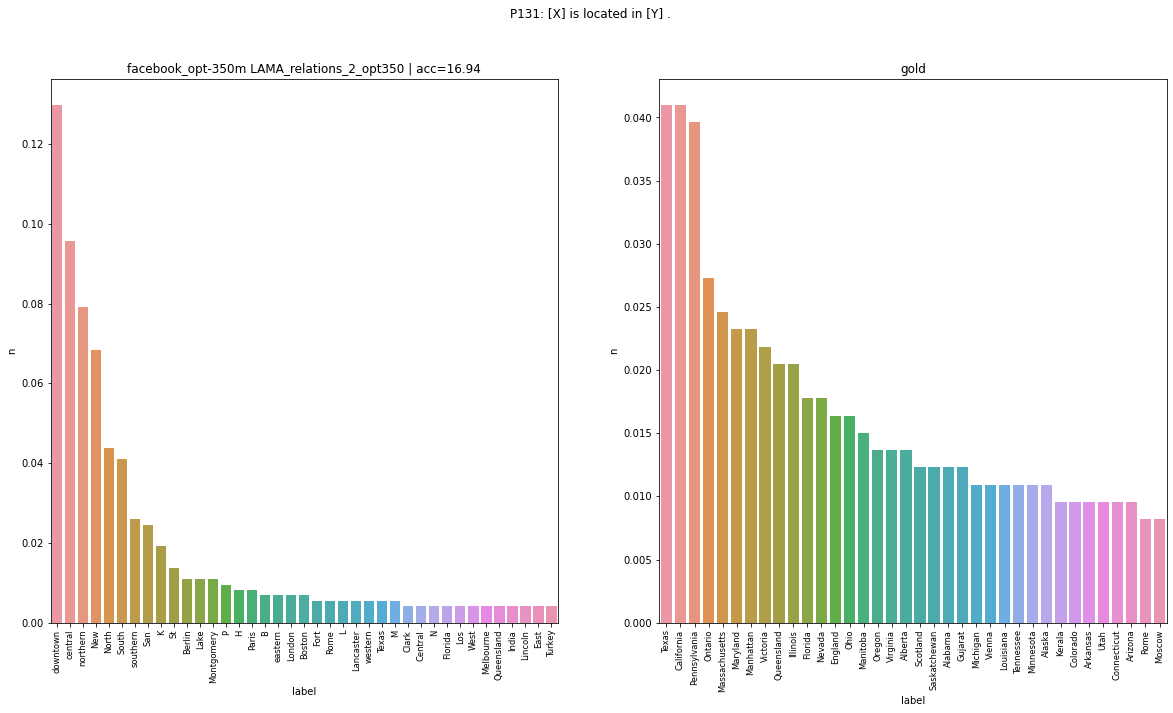

P136	0.13	(1 / 744)


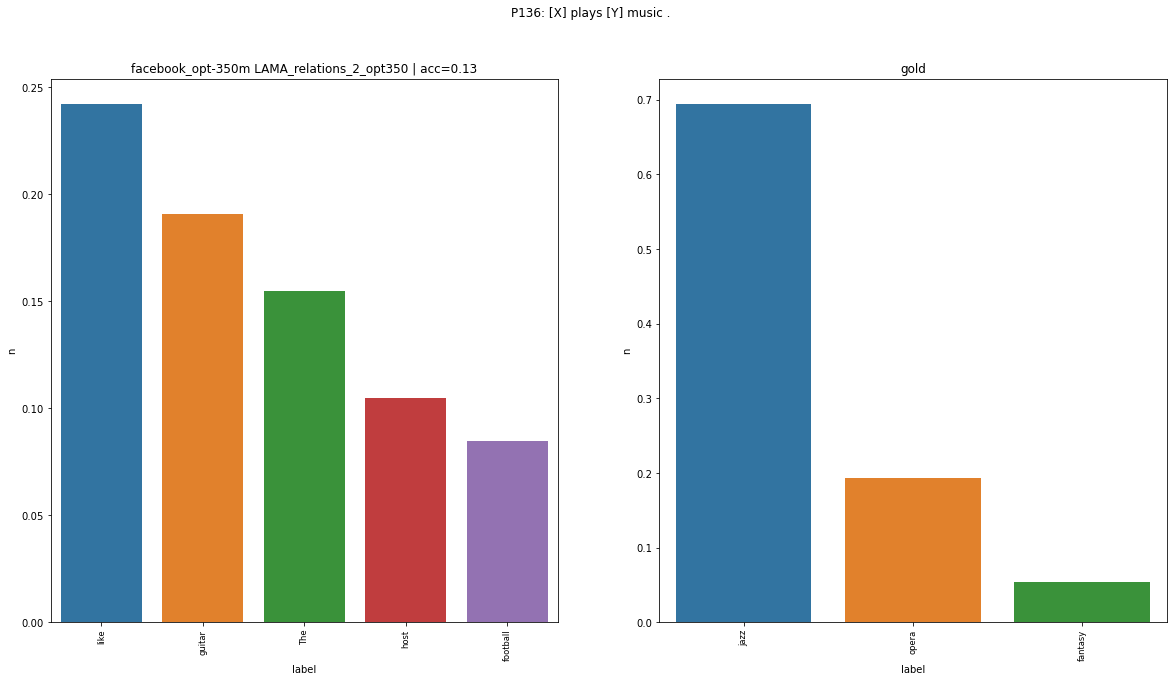

P1376	83.89	(125 / 149)


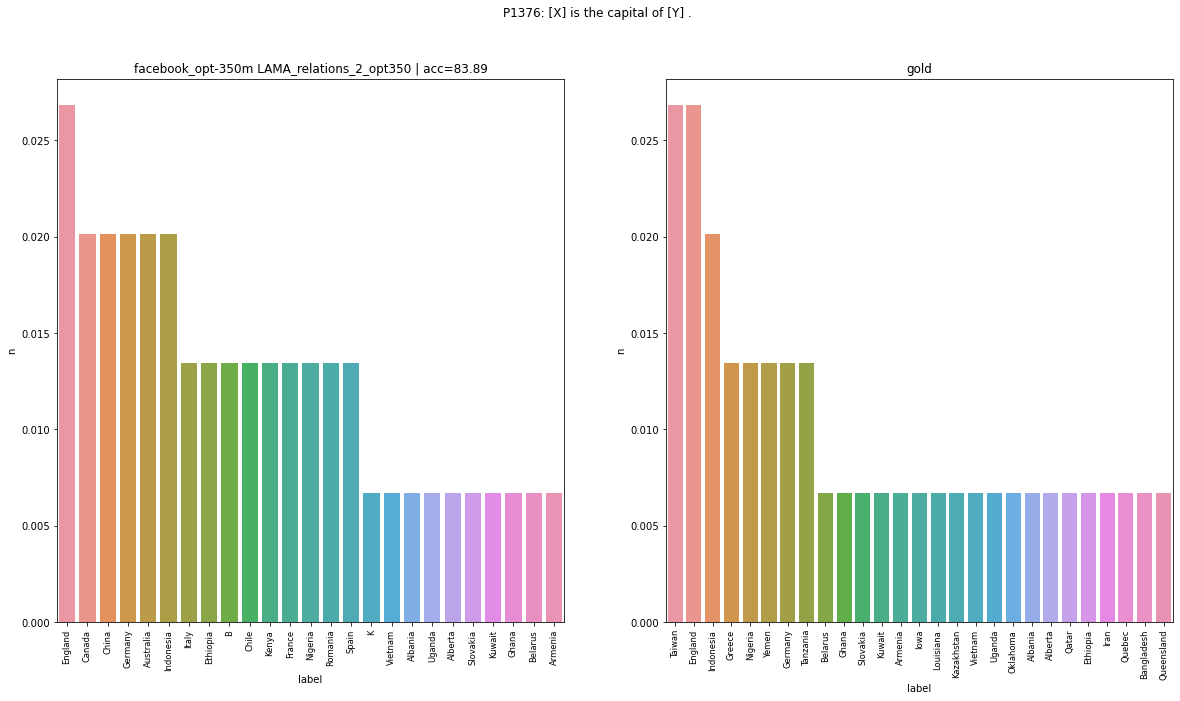

P138	29.60	(111 / 375)


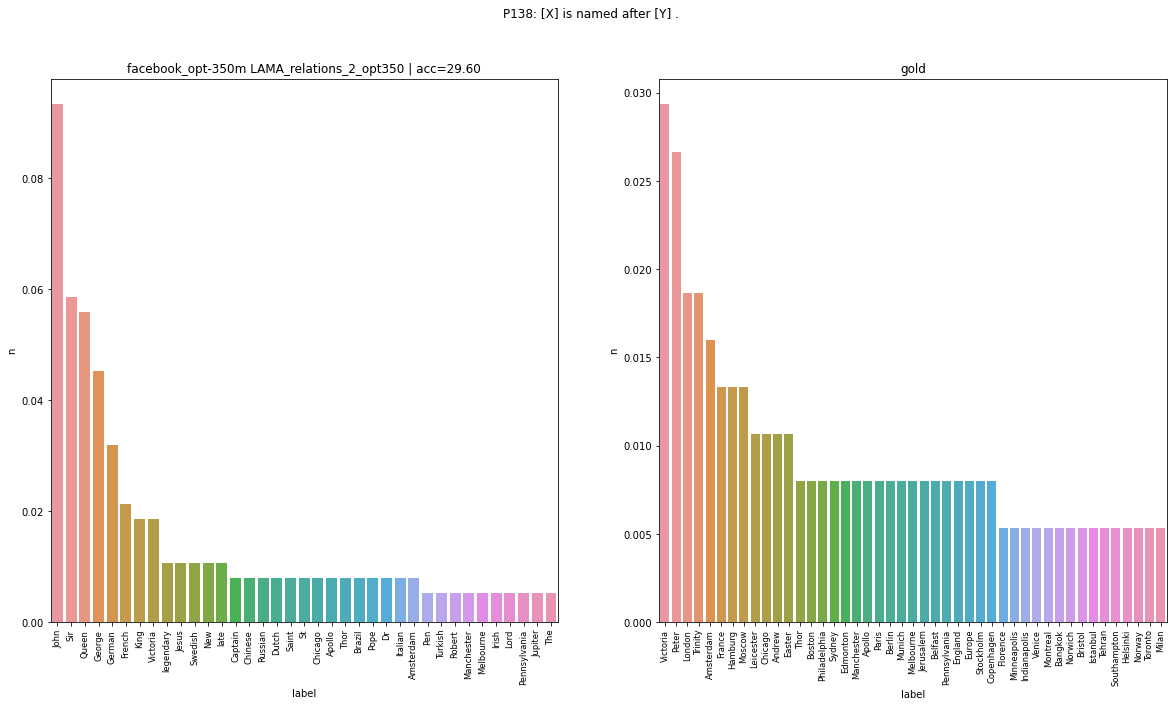

P140	0.00	(0 / 382)


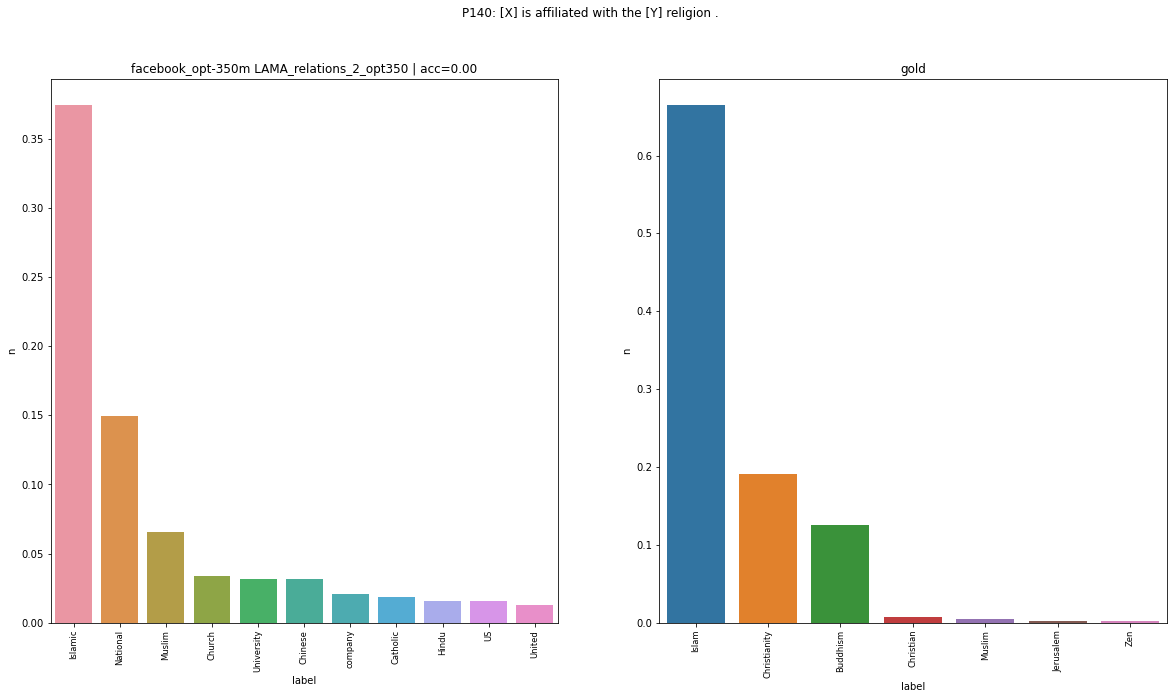

P1412	68.40	(604 / 883)


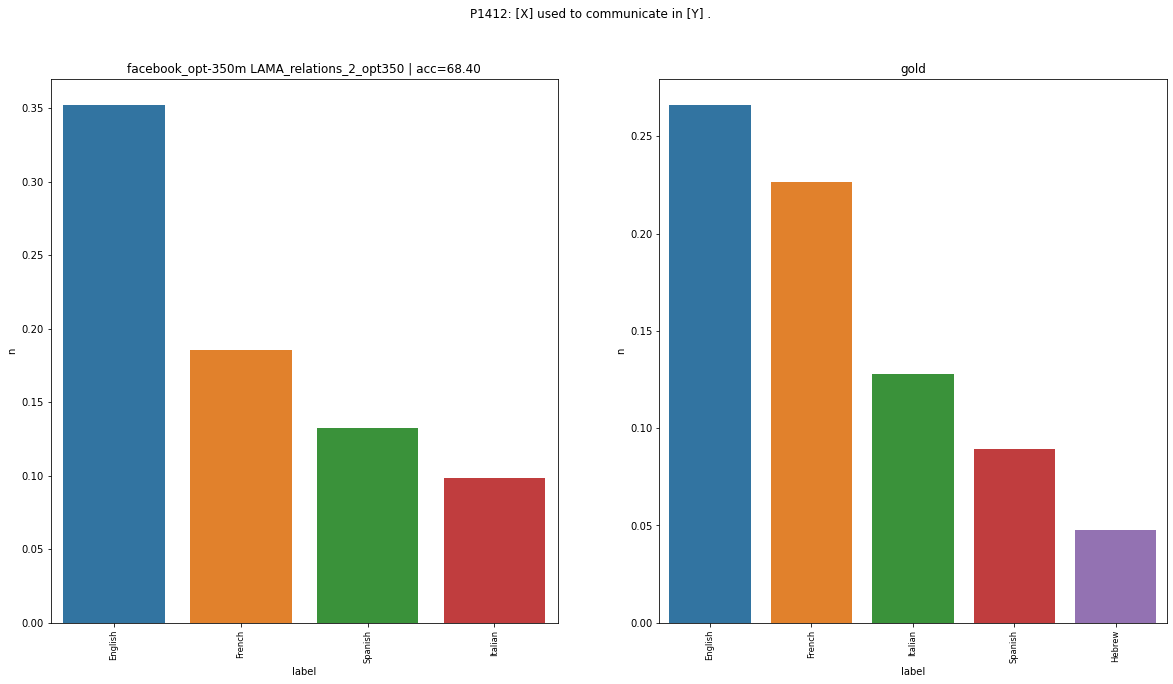

P159	29.07	(218 / 750)


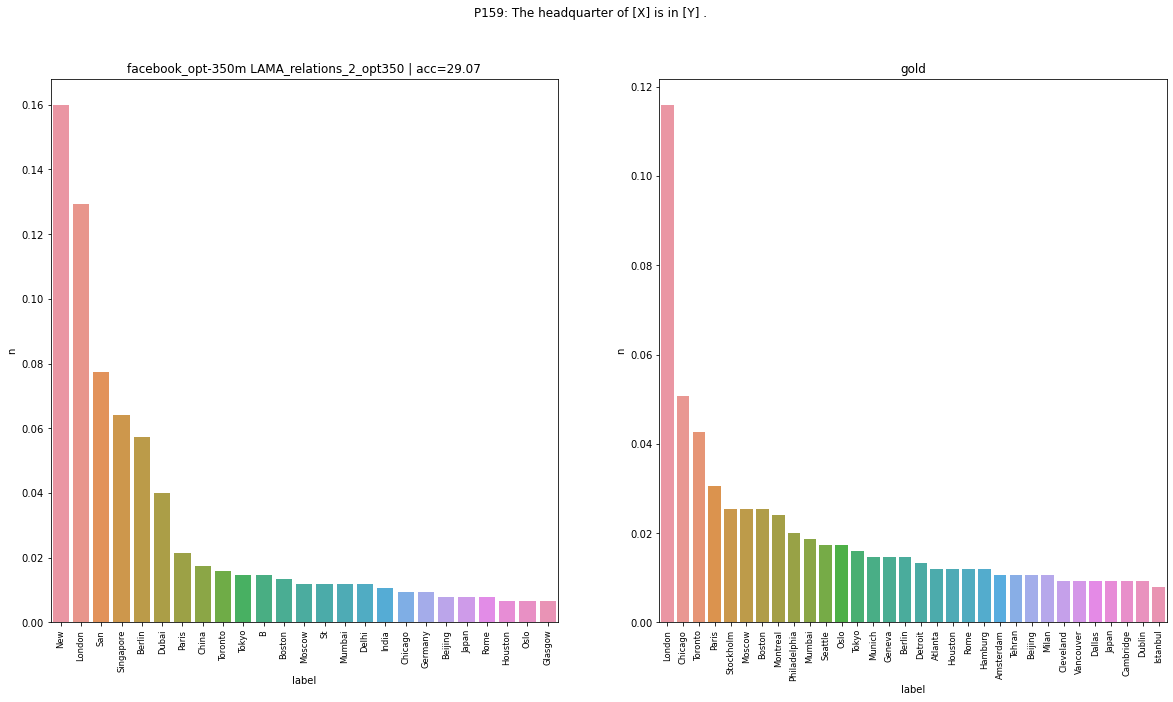

P17	9.56	(86 / 900)


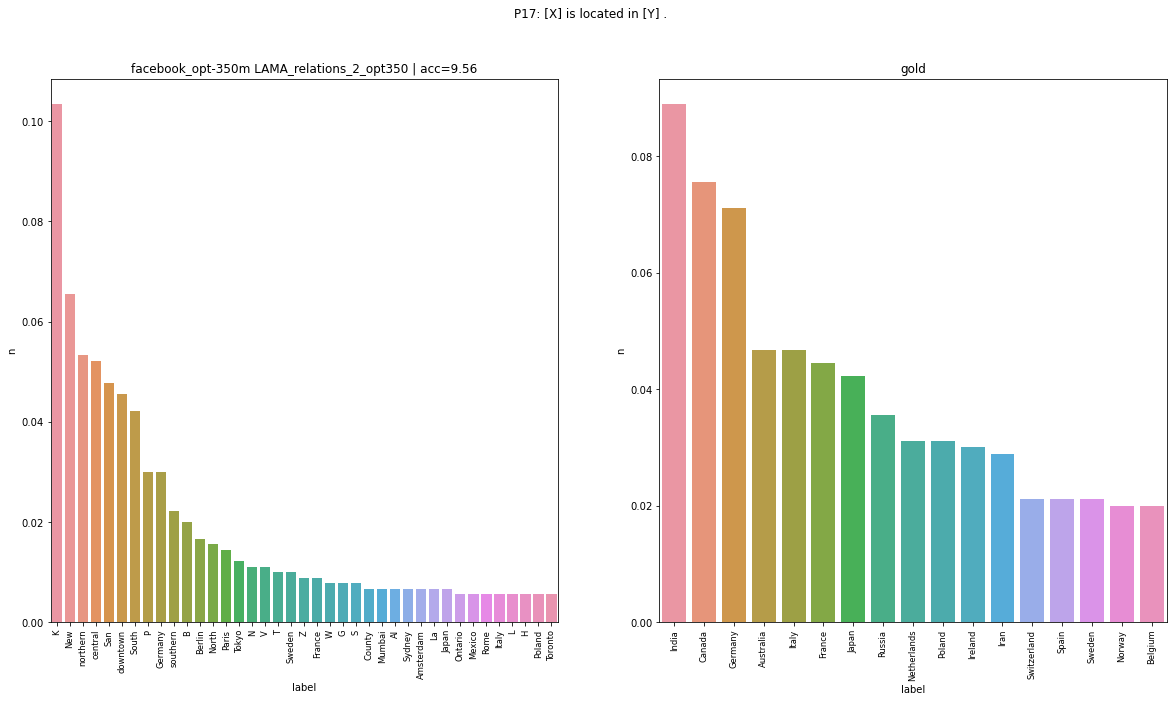

P176	88.37	(760 / 860)


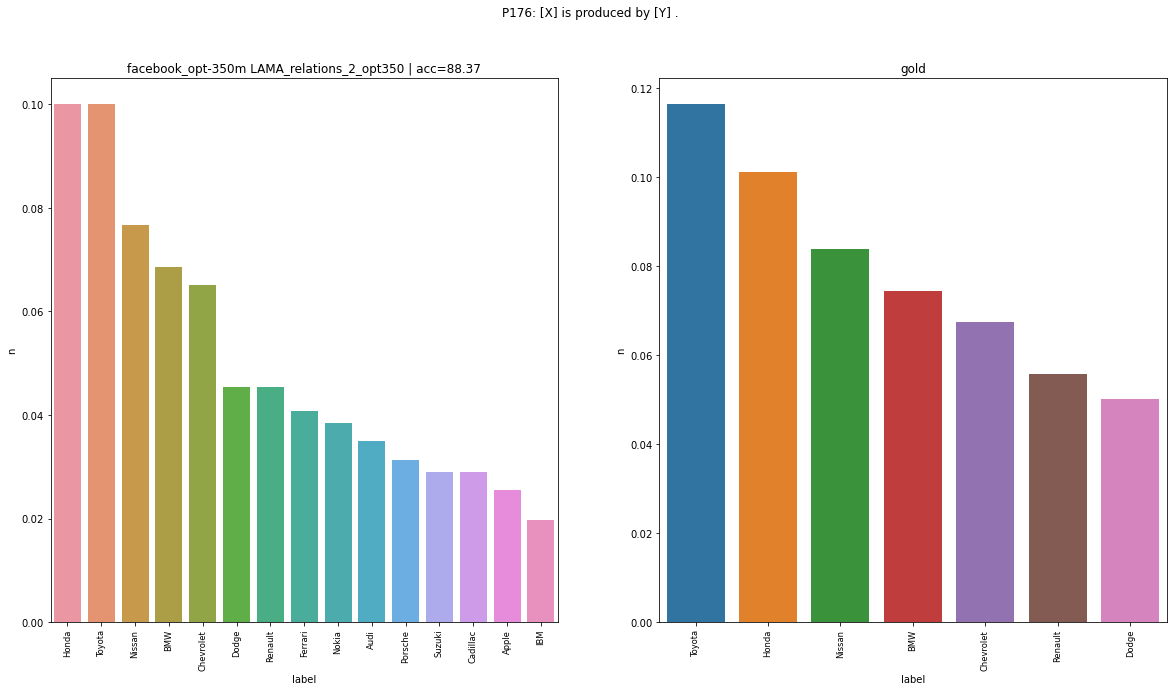

P178	71.14	(392 / 551)


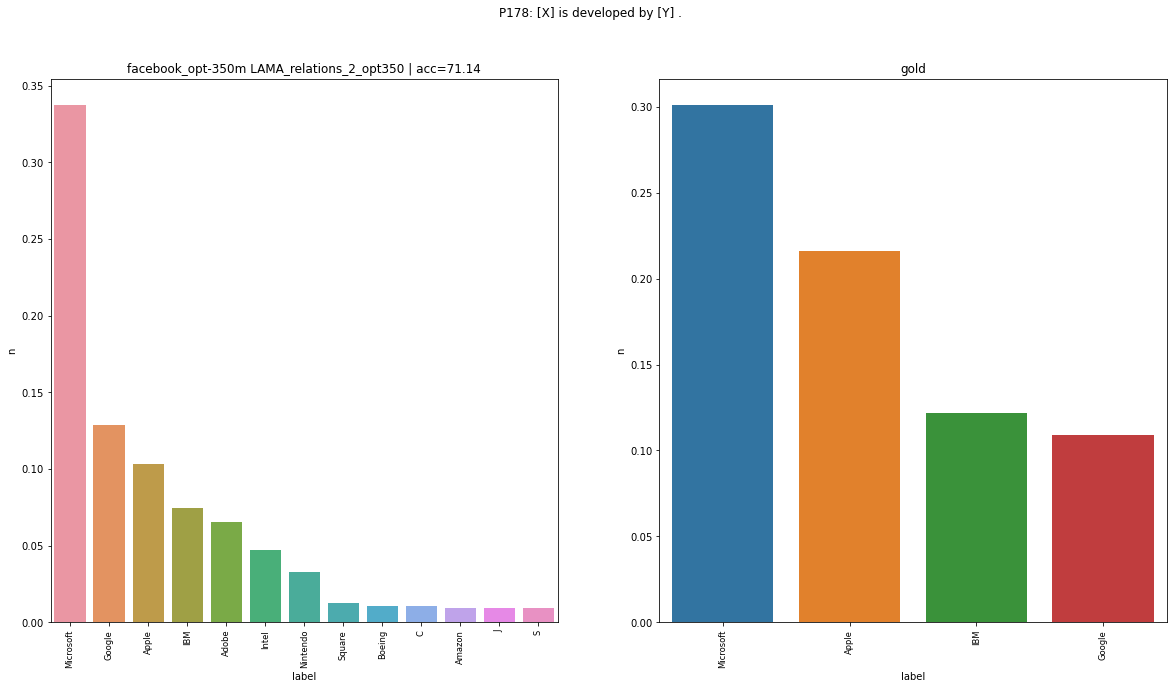

P19	12.22	(86 / 704)


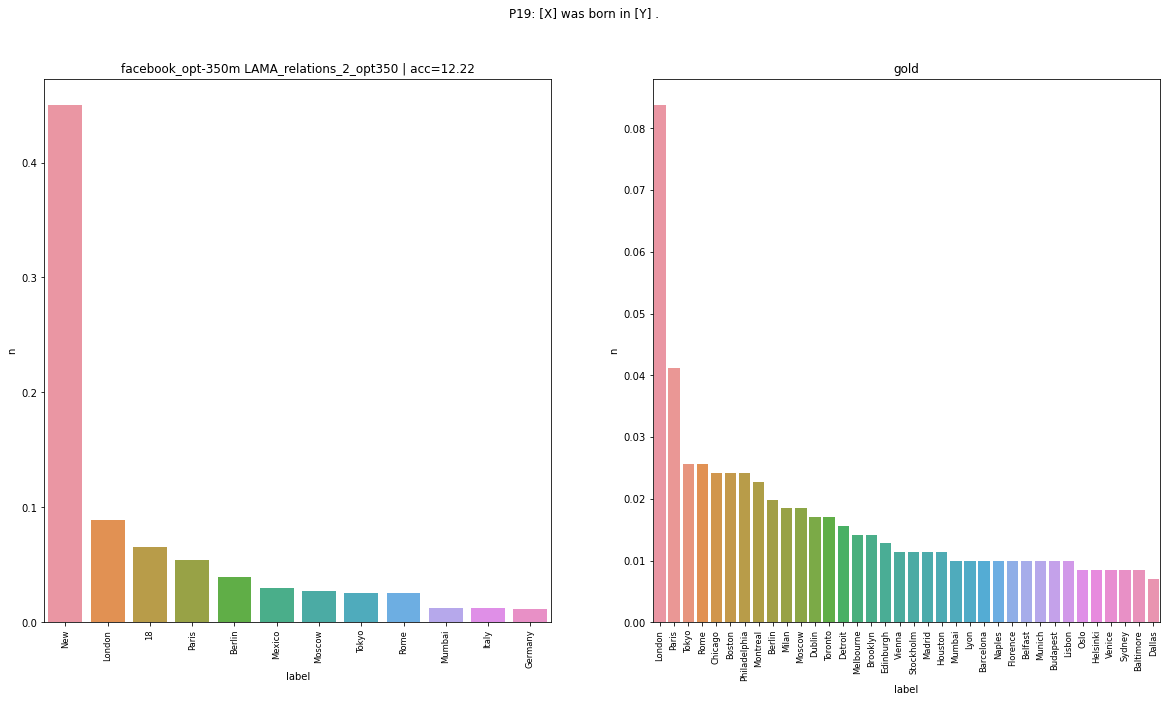

P190	1.43	(8 / 559)


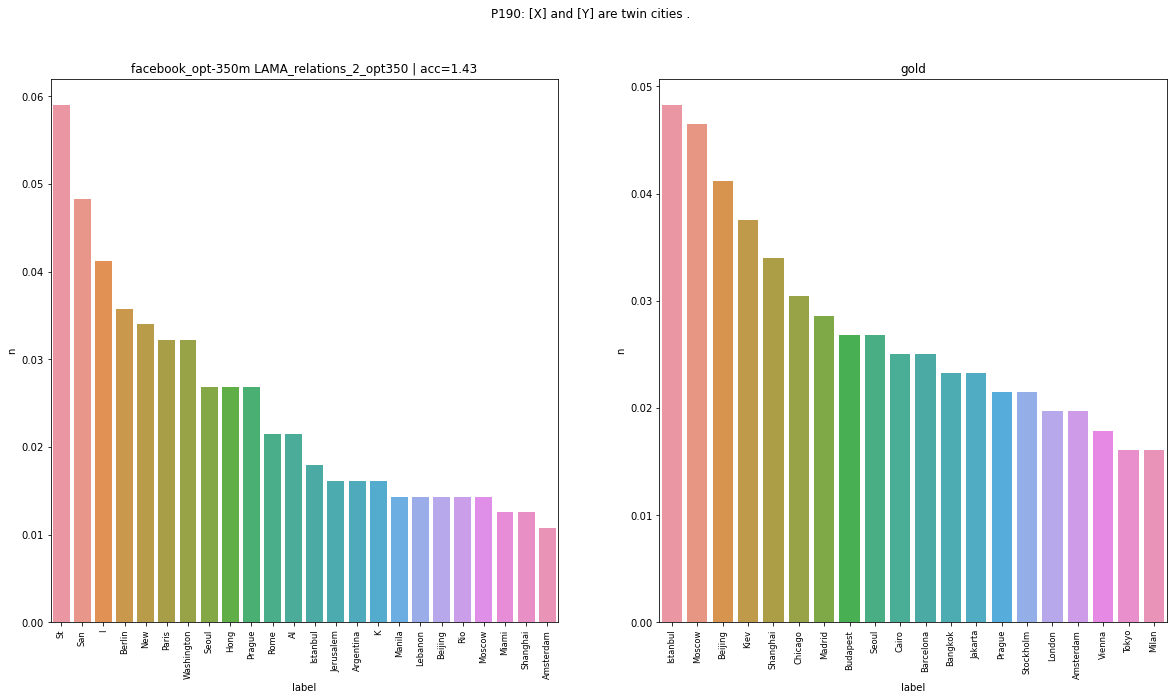

P20	6.92	(52 / 751)


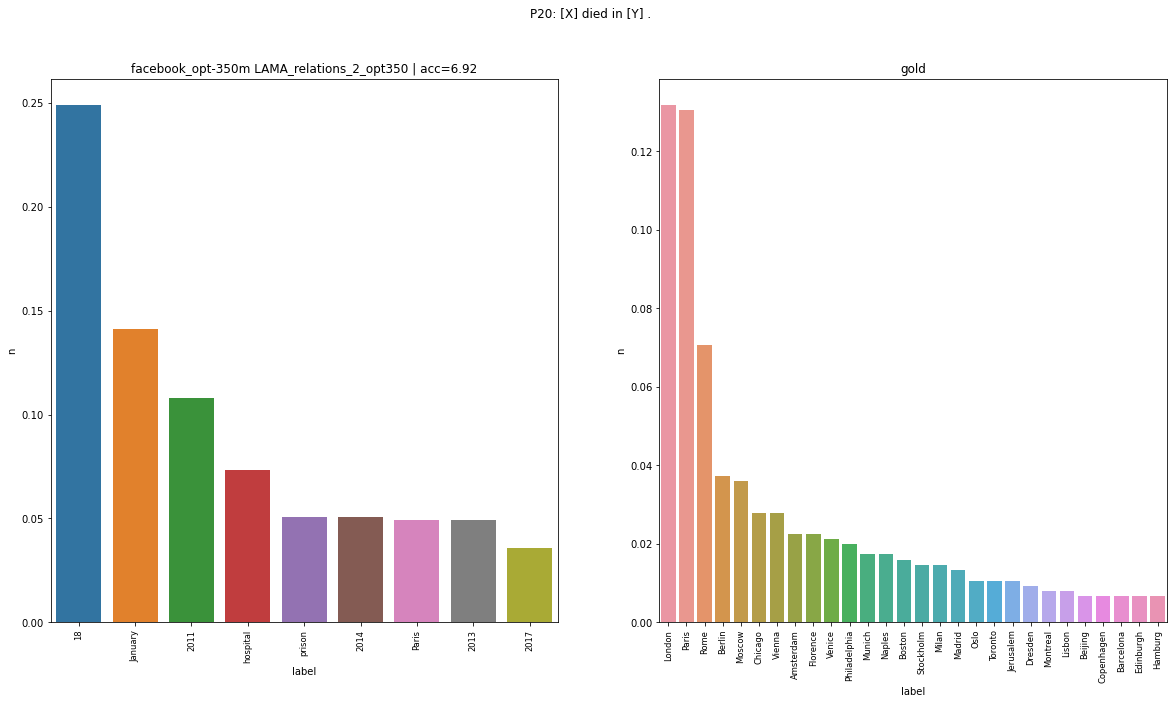

P264	0.00	(0 / 48)


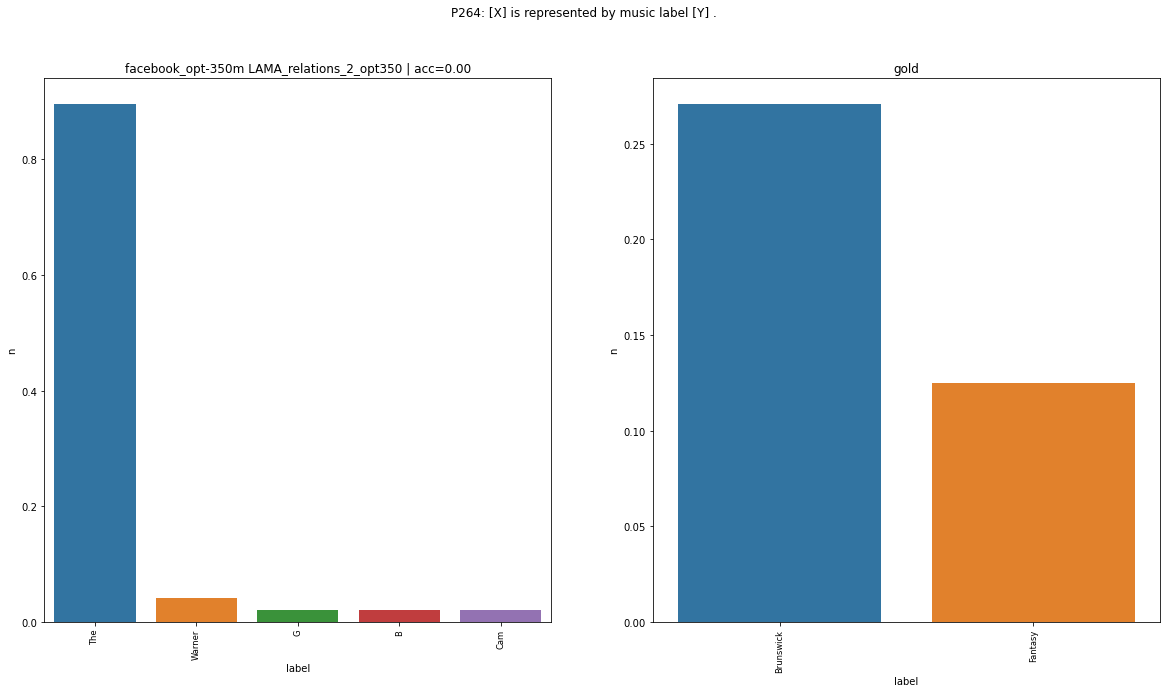

P27	0.11	(1 / 942)


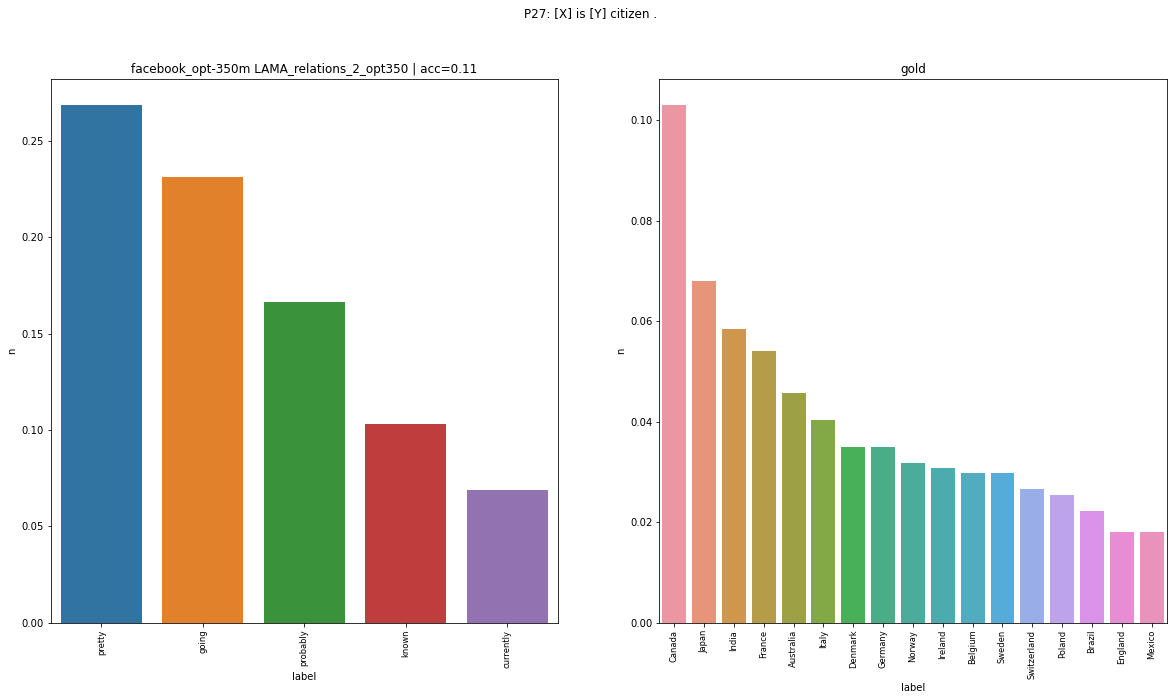

P276	38.79	(263 / 678)


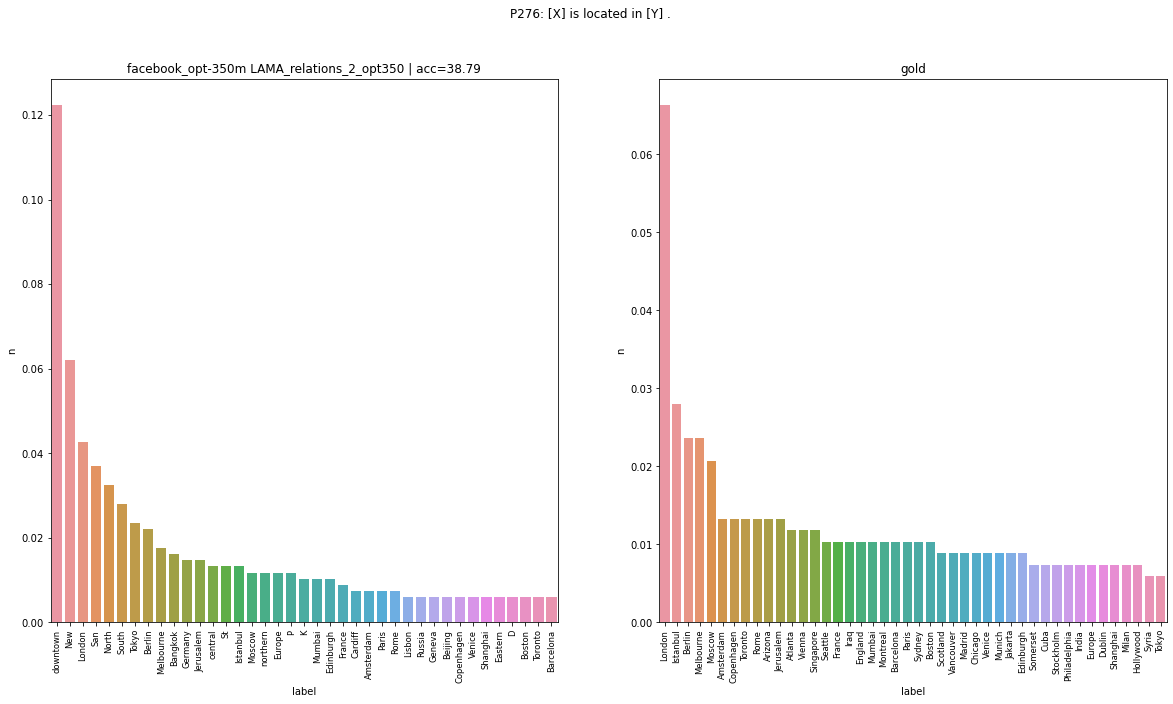

P279	29.45	(230 / 781)


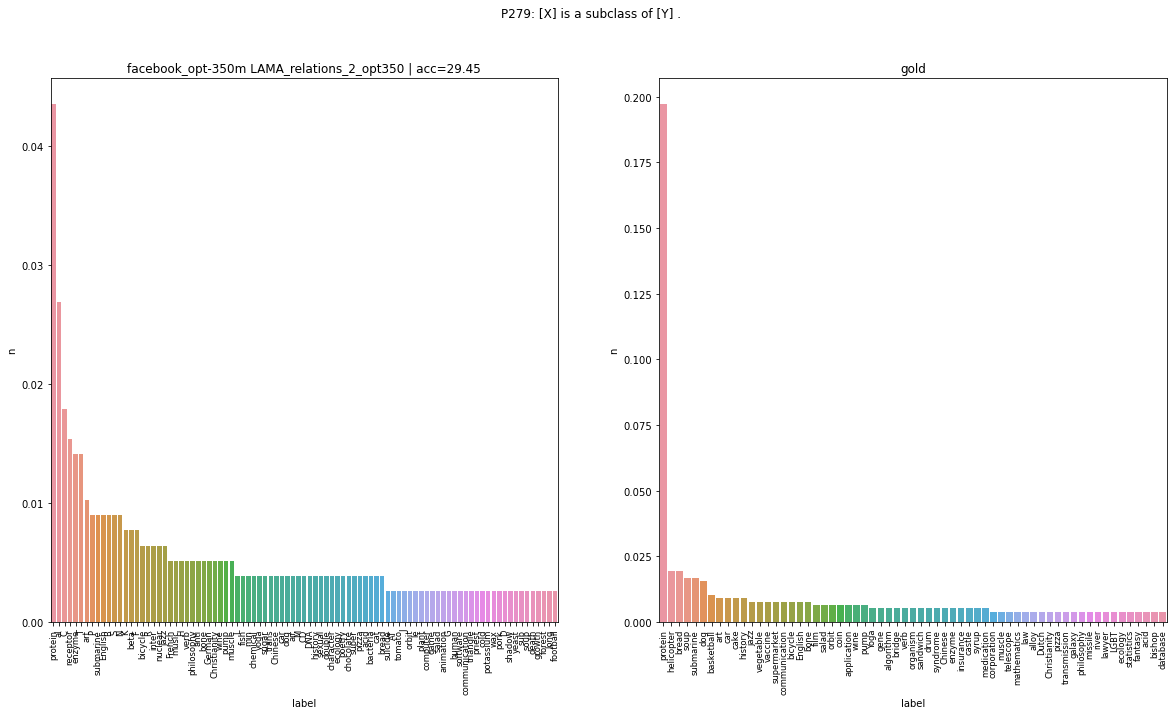

P30	9.24	(23 / 249)


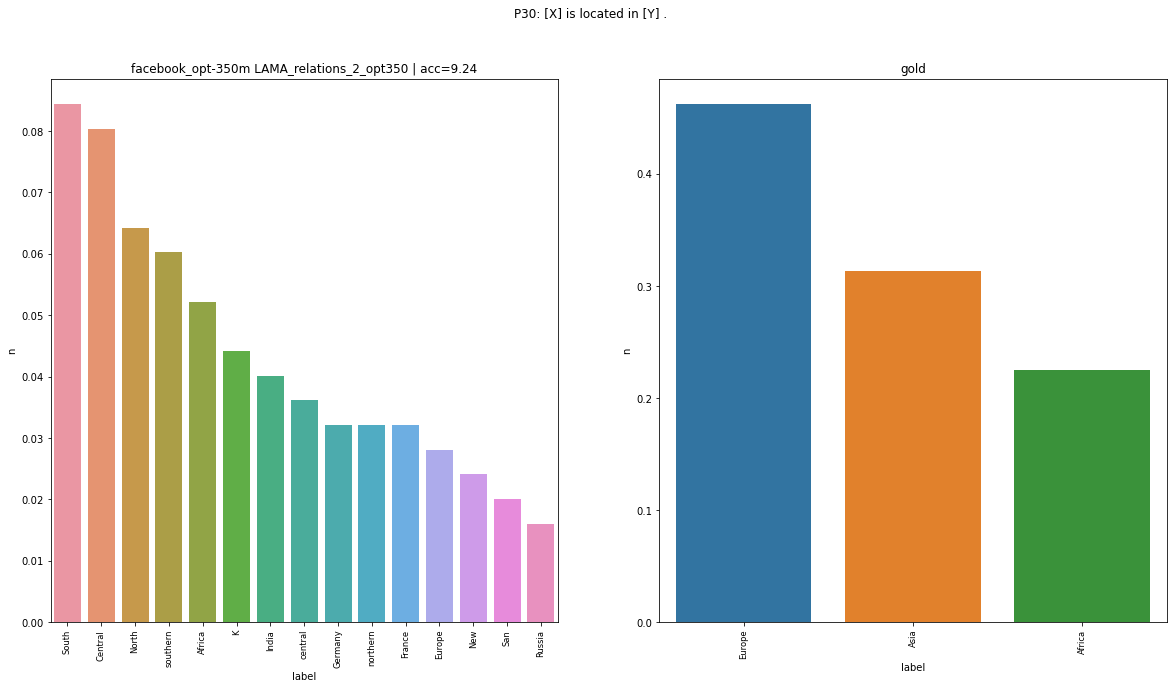

P31	2.62	(21 / 803)


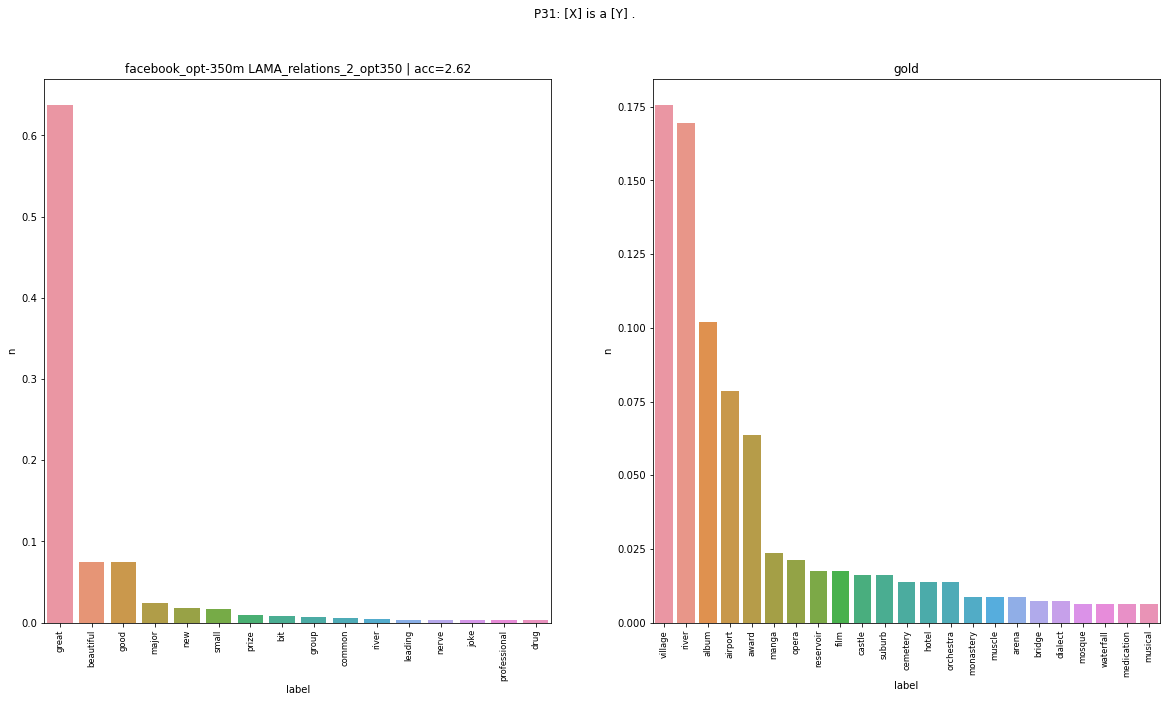

P36	51.96	(186 / 358)


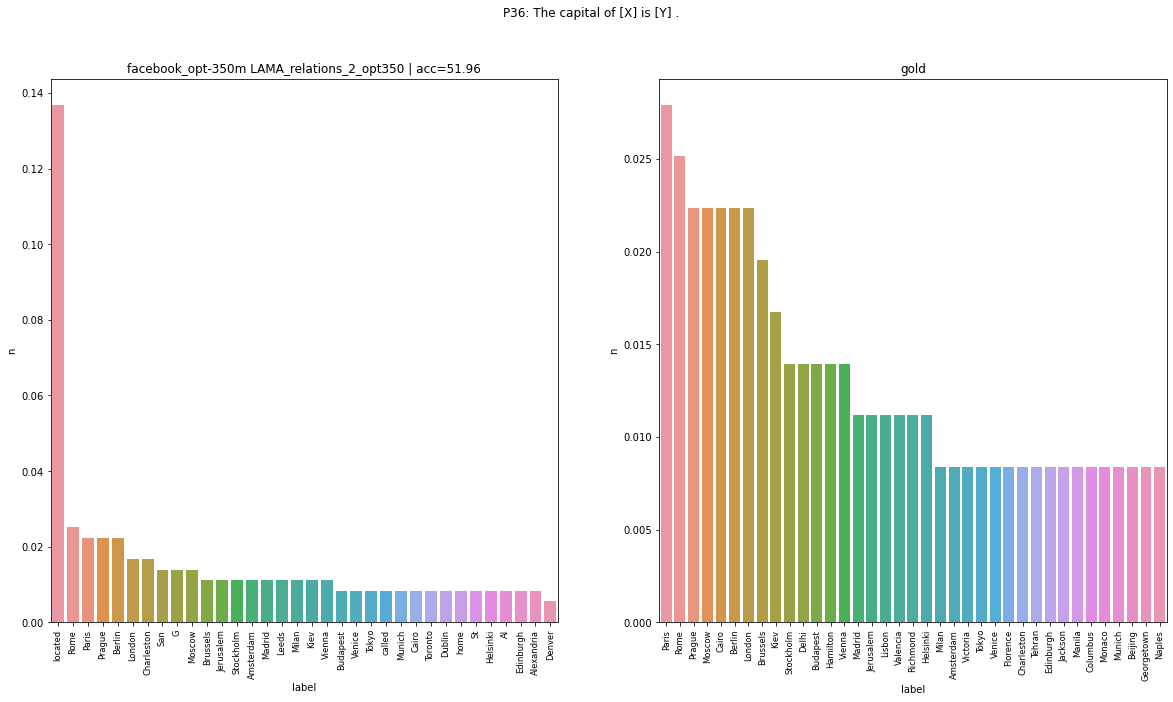

P361	23.71	(138 / 582)


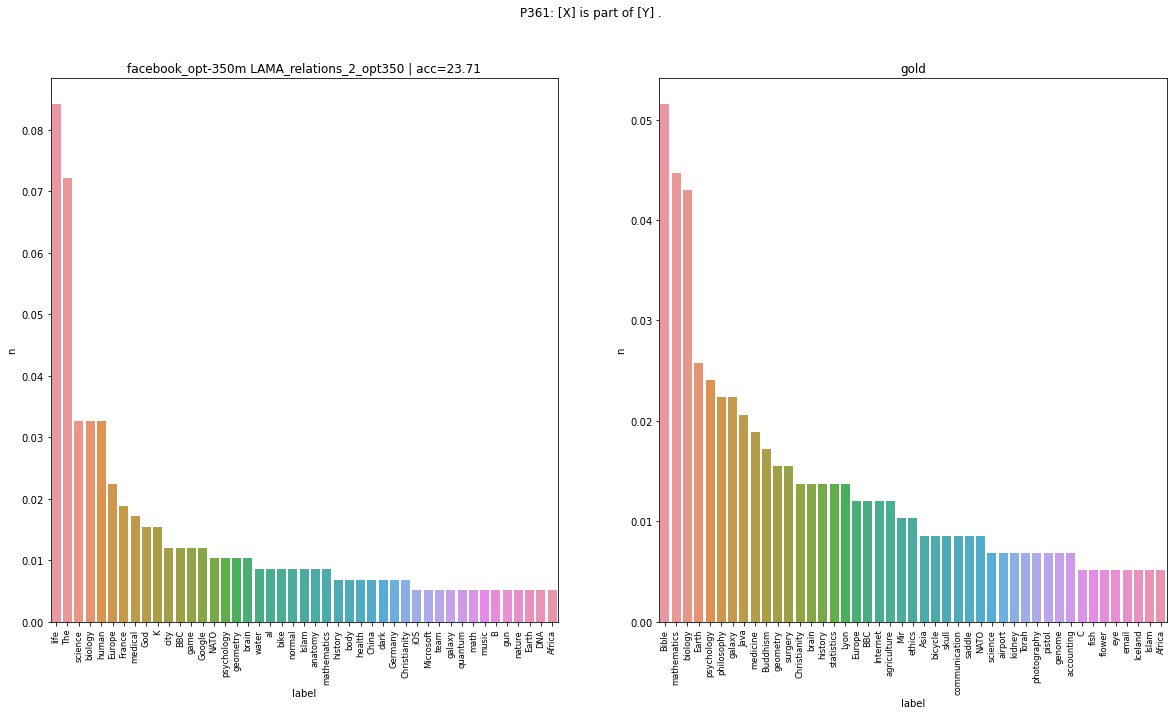

P364	49.79	(363 / 729)


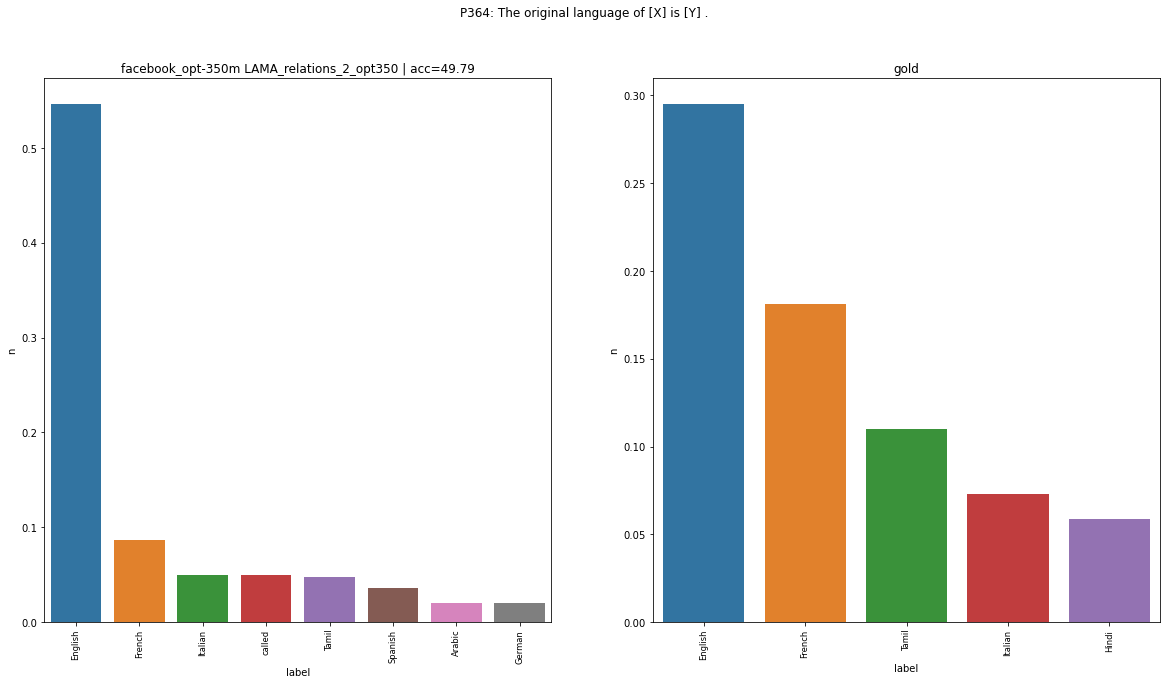

P37	51.77	(439 / 848)


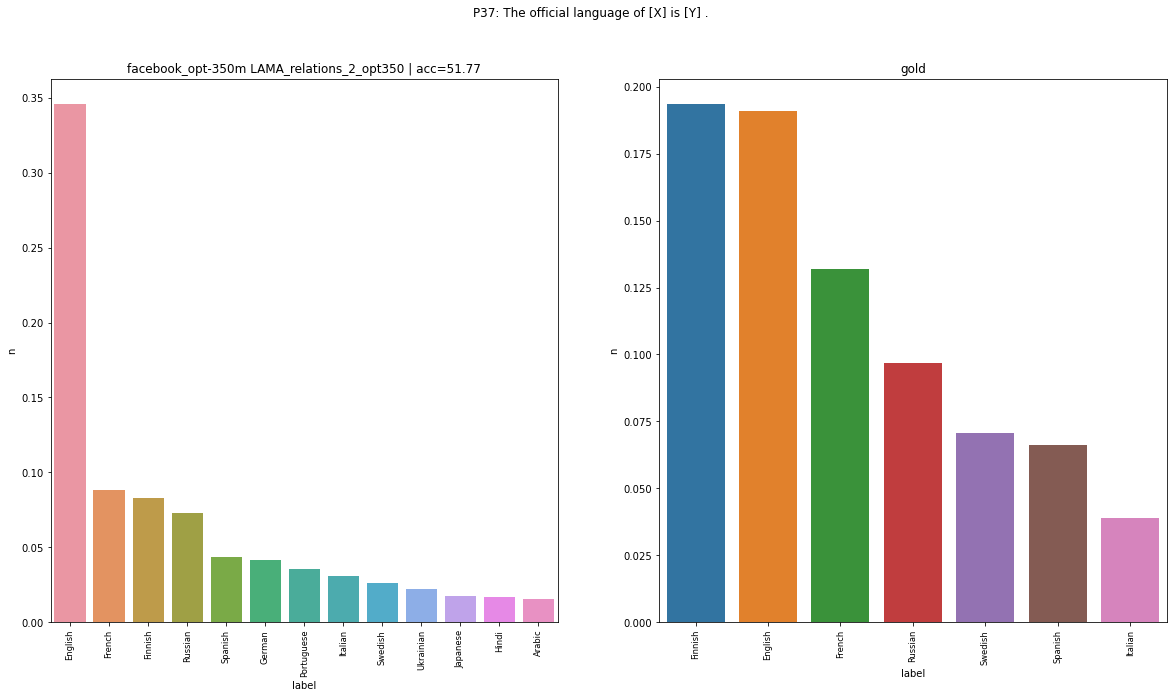

P39	3.59	(11 / 306)


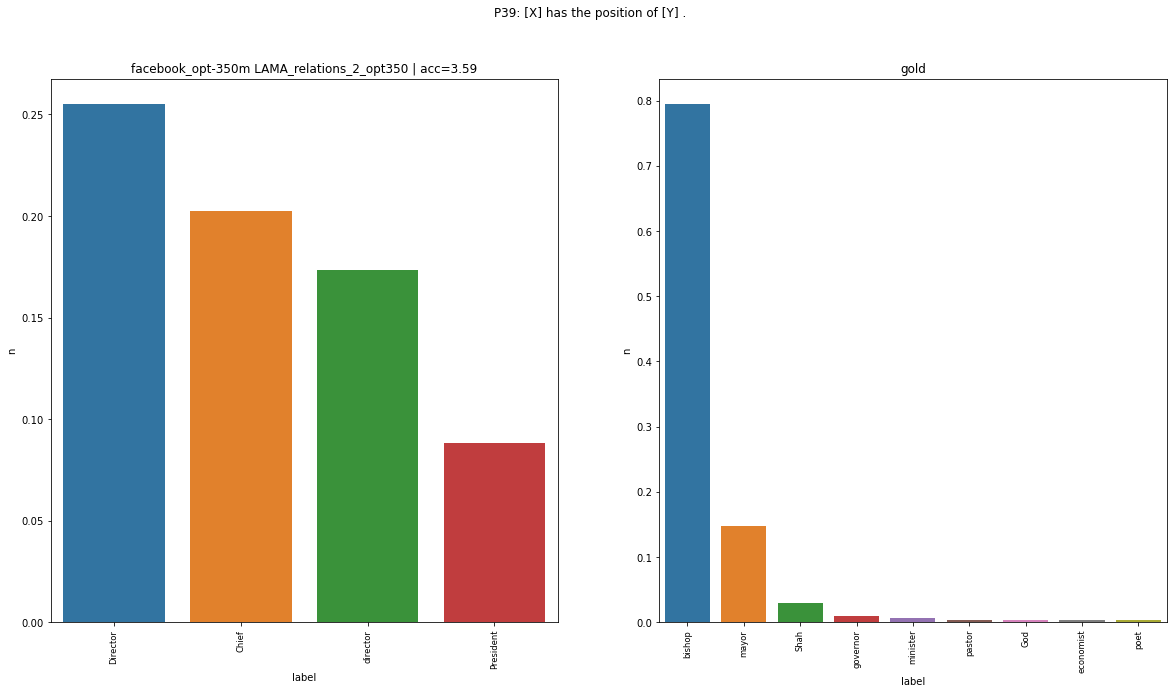

P407	17.73	(147 / 829)


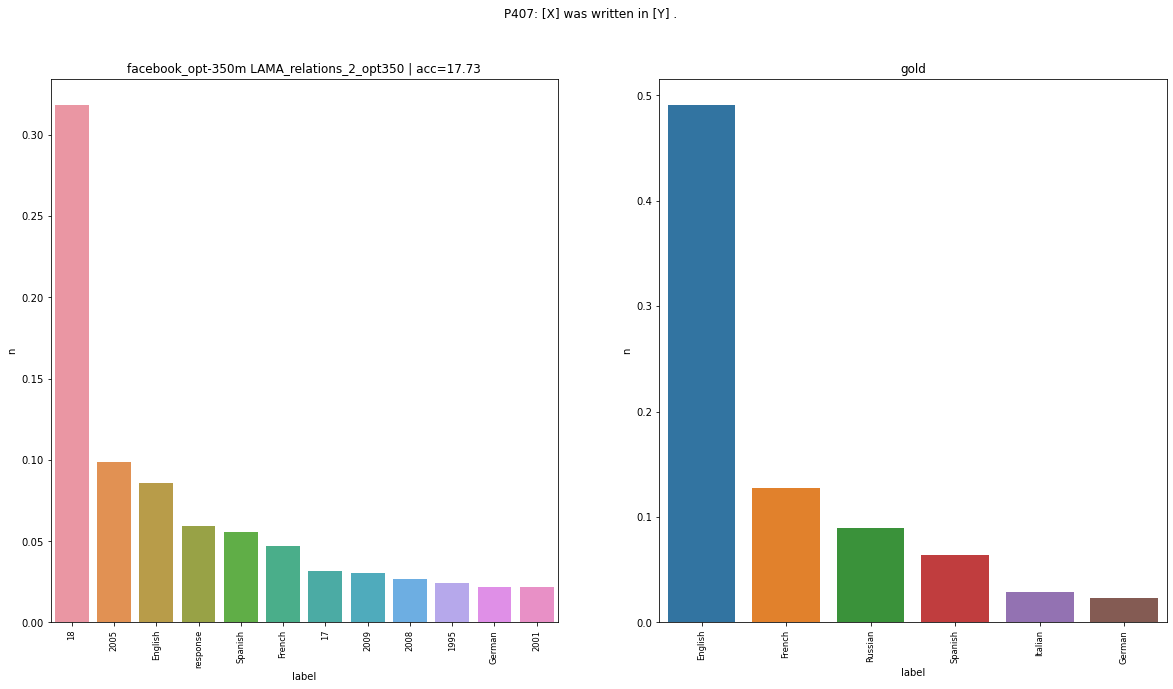

P413	0.00	(0 / 271)


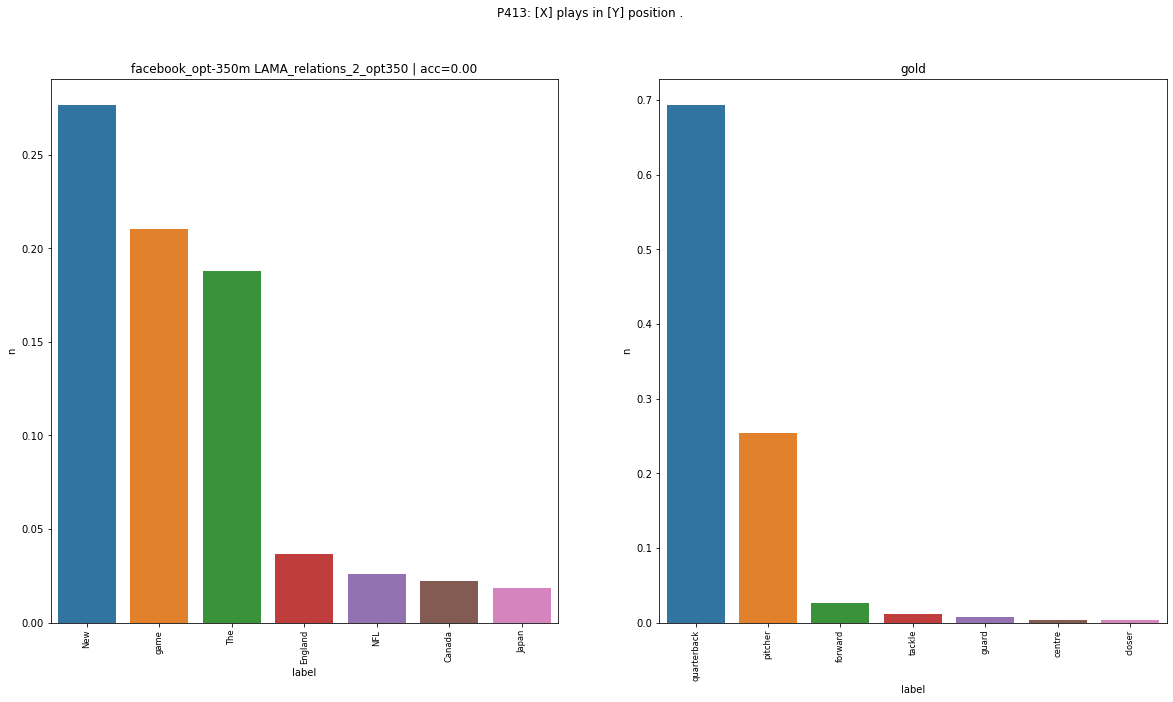

P449	30.35	(122 / 402)


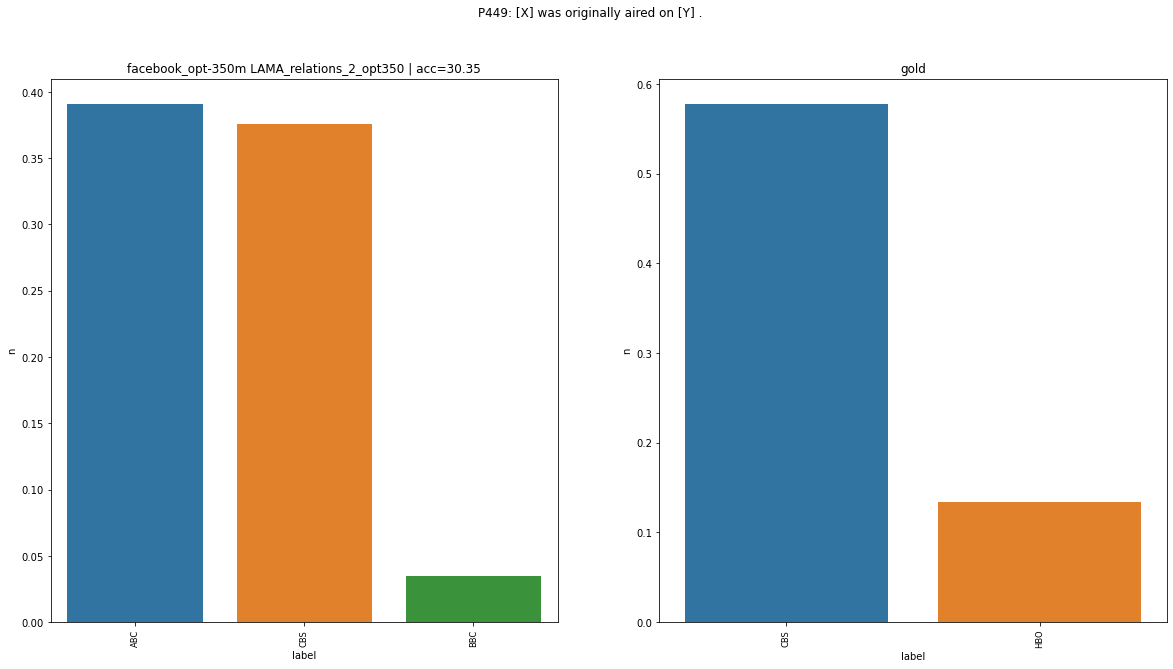

P463	78.86	(138 / 175)


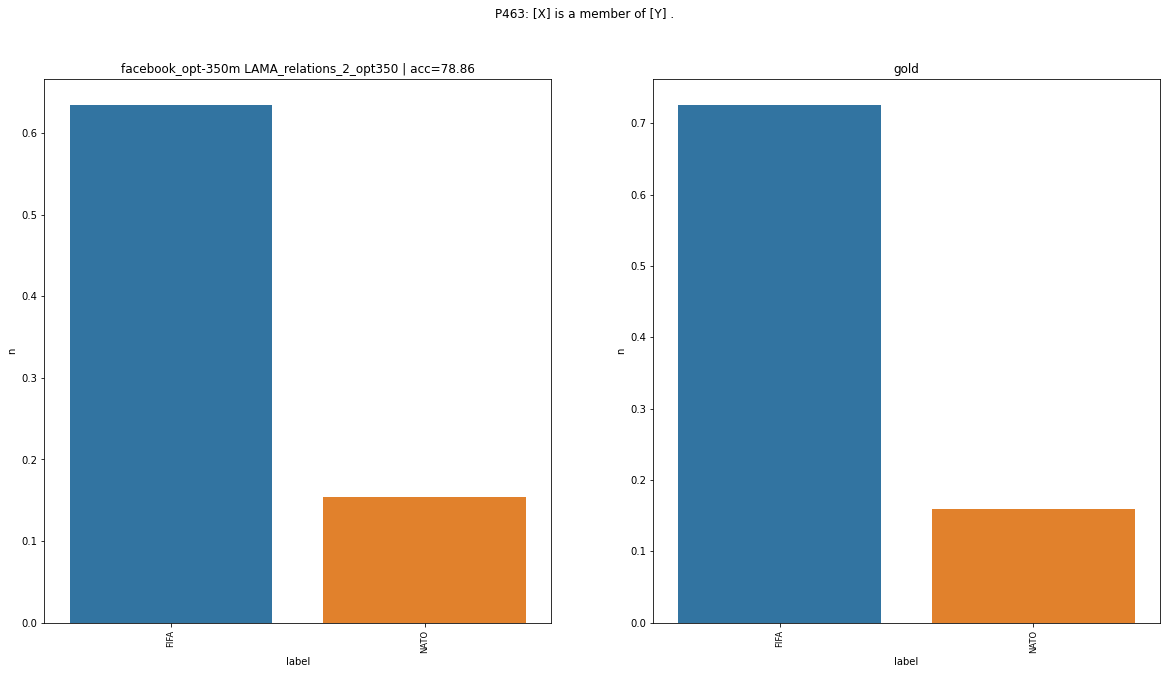

P47	11.99	(70 / 584)


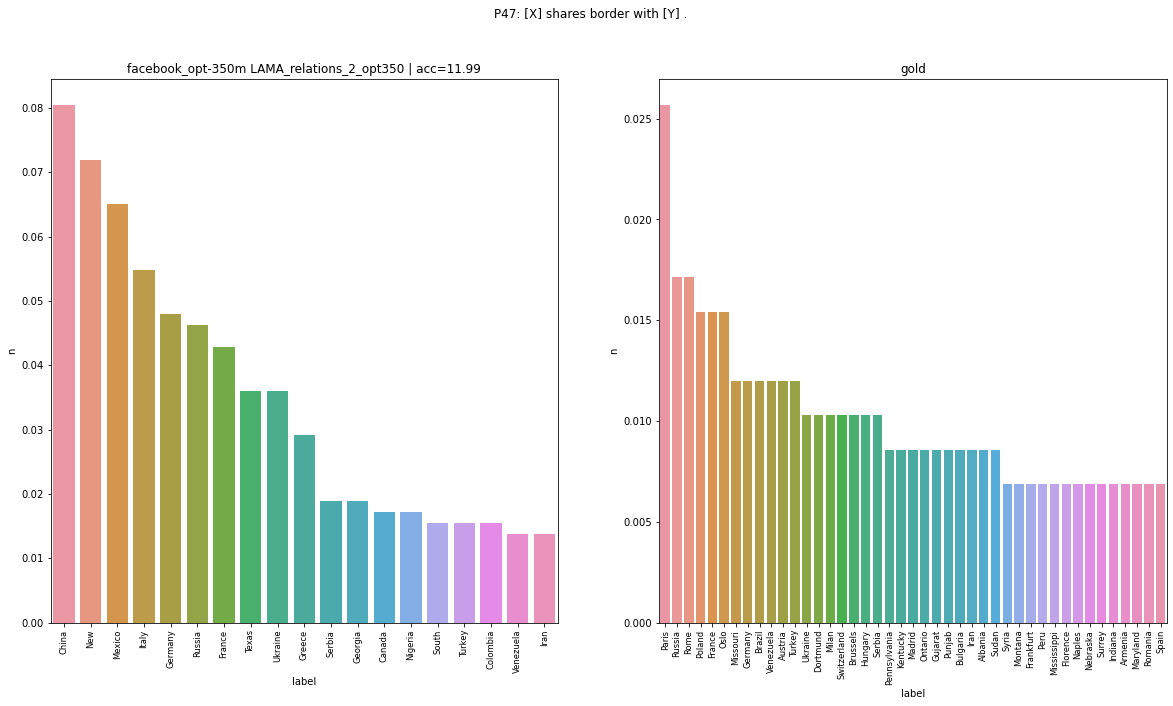

P495	6.65	(60 / 902)


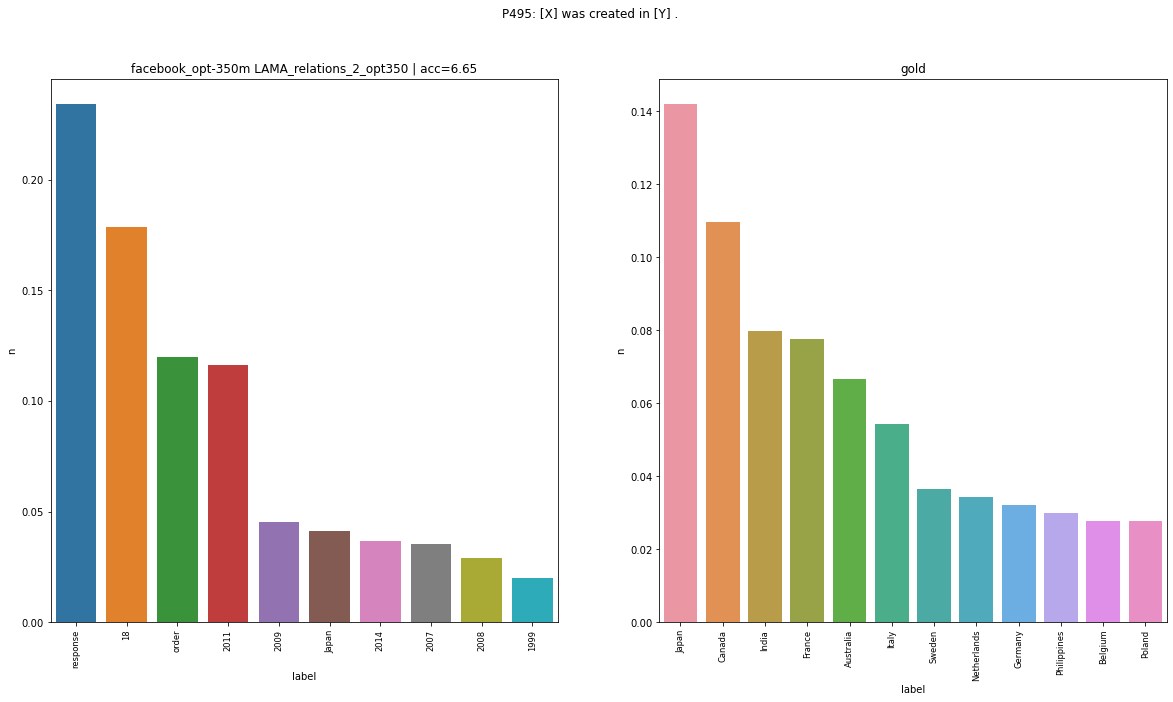

P527	19.17	(175 / 913)


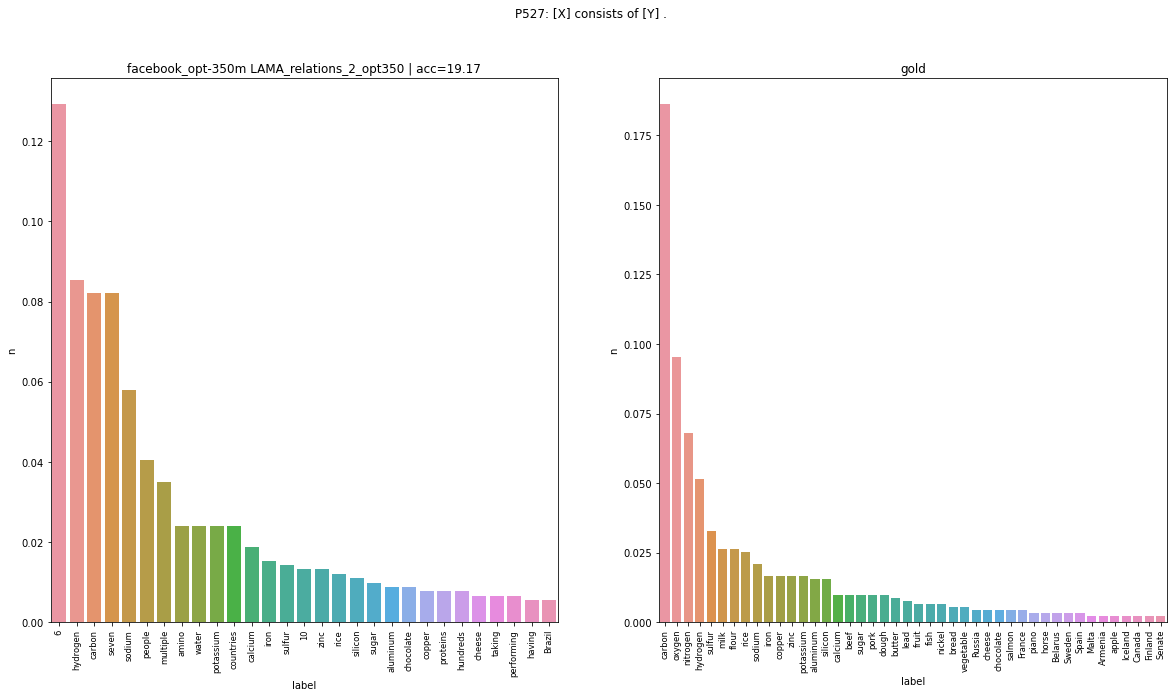

P530	3.16	(29 / 918)


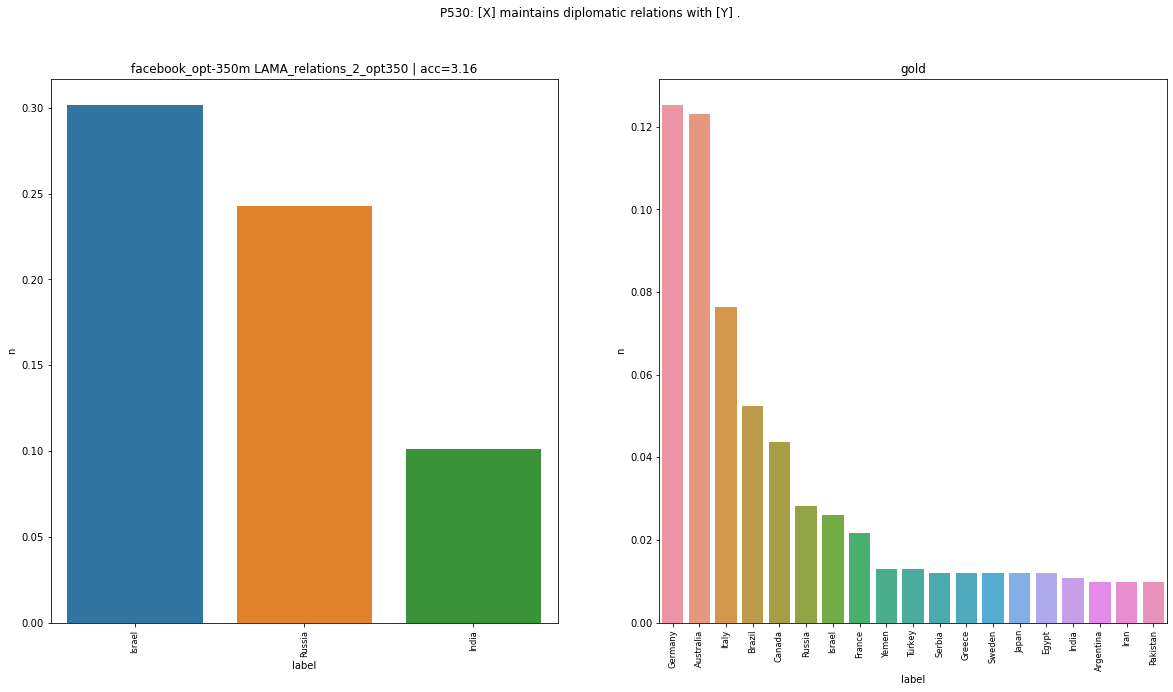

P740	0.25	(2 / 814)


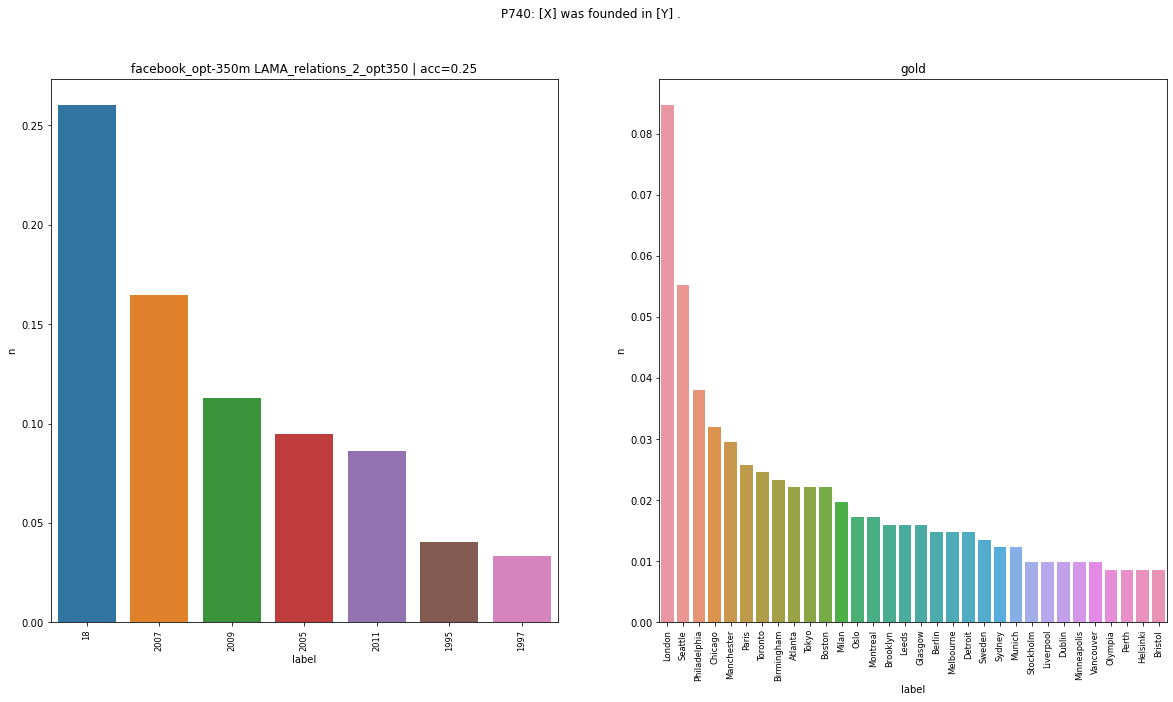

P937	14.86	(122 / 821)


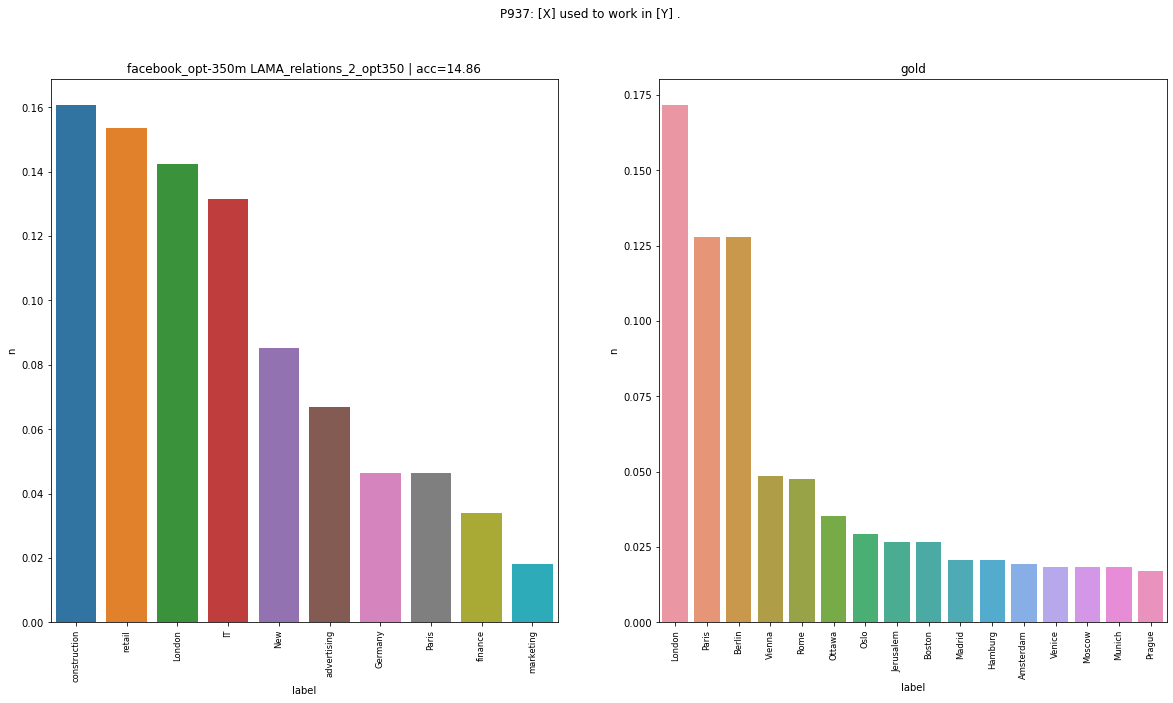

Macro: 25.78	(6534 / 25345)
Micro: 26.03


In [6]:
plt.rcParams['figure.figsize'] = [20, 10] # trick to change fig size in a notebook

tot = 0
cor = 0

rel_avg = []

# Load templates
templates = load_file(LAMA_template)
templates = {t['relation']:t for t in templates}

n_models = len(data)

if rel_id=='all': # global analysis
    tot = 0
    cor = 0
    rel_avg = []
    rel_p1 = {'gold':{}, 'pred':{}}
    for relation in relations:

        template = templates[relation]['template']
        fig = plt.Figure((64, 40))
        
        for n, datum in enumerate(data): # iterate accross models
            m=datum['model']
            ppt=datum['prompts']
            dir=os.path.join('../output', ppt, m)

            scores, rel_pred_stats, rel_gold_stats = get_rel_stats(relation, dir=dir)
            rel_cor, rel_tot = scores

            # Accuracy
            acc = (rel_cor / rel_tot * 100)
            print('%s\t%.2f\t(%d / %d)'%(relation, acc, rel_cor, rel_tot))
            rel_avg.append(rel_cor / rel_tot)
            tot += rel_tot
            cor += rel_cor

            # Answer distribution (accross samples)
            # rel_p1['pred'][relation]=prop_top1(rel_pred_stats)
            # rel_p1['gold'][relation]=prop_top1(rel_gold_stats)
            # rel_norment = normentropy(list(rel_pred_stats.values()))

            plt.subplot(1,n_models+1,1+n)
            display_ans_dist(rel_pred_stats, fig, only_head=True)
            plt.title(m+' '+ppt+' | acc=%.2f'%acc)
            plt.xticks(rotation = 90, fontsize = 'small')

        plt.subplot(1,n_models+1,n_models+1)
        display_ans_dist(rel_gold_stats, fig, only_head=True)
        plt.title('gold')
        plt.xticks(rotation = 90, fontsize = 'small')
        
        plt.suptitle(relation+': '+template)
        #extra
        
        plt.show()
    # print(rel_p1)

    micro = sum(rel_avg) / len(rel_avg) * 100
    macro = cor / tot * 100
    print('Macro: %.2f\t(%d / %d)'%(macro, cor, tot))
    print('Micro: %.2f'%(micro))
else: # One relation at a time
    relation='P'+rel_id
    scores, rel_pred_stats, rel_gold_stats = get_rel_stats(relation)
    rel_cor, rel_tot = scores
    print('%s\t%.2f\t(%d / %d)'%(relation, (rel_cor / rel_tot * 100), rel_cor, rel_tot))
    
    # Answer distribution (accross samples)
    rel_norment = normentropy(list(rel_pred_stats.values()))
    gold_rel_norment = normentropy(list(rel_gold_stats.values()))

    print('Pred norment:',rel_norment)
    print('Gold norment:',gold_rel_norment)


    plt.subplot(1,2,1)
    display_ans_dist(rel_pred_stats, fig)
    plt.title(model)
    plt.xticks(rotation = 90, fontsize = 'xx-small')

    plt.subplot(1,2,2)
    display_ans_dist(rel_gold_stats, fig)
    plt.title('gold')
    plt.xticks(rotation = 90, fontsize = 'xx-small')
    
    plt.suptitle(relation)
    plt.plot()


